# Imports

In [1665]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import subprocess
import os as os
import seaborn as sns
import seaborn.objects as so
import collections as co
from matplotlib.colors import LogNorm, Normalize, LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from glob2 import glob
from datetime import datetime
import pytz
from tqdm import tqdm
import random

In [1666]:
dcml_chordtype_map = {
    "M": "major",
    "m": "minor",
    "Mm7": "dominant-7th",
    "o": "diminished",
    "o7": "full-diminished",
    "mm7": "minor-7th",
    "%7": "half-diminished",
    "MM7": "major-7th",
    "+": "augmented",
    "mM7": "minor-major-7th",
    "+7": "augmented-7th",
}

----

## Loading the Results
Loads all json files from the given folders

In [1800]:
def get_experiments(experiment_name):
    cols = ['id', 'corpus', 'piece', 'algorithm', 'accuracy', 'likelihood', 'chordLabels', 'slices','runTime', 'reruns','groundTruth']
    df = pd.DataFrame(columns=cols) 
    lbls = pd.DataFrame(columns=["piece", "corpus", "labels"])
    
    path = "outputs"
    experiments, experiment_types = get_all_experiments(path)
    if experiment_name in experiment_types:
        print("Getting runs of {}".format(experiment_name))
    else:
        print("Can't find experiment {}".format(experiment_name))
        return 
    
    fails = [] 
    successes = 0
    lbl_list = []
    df_list = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if experiment_name in file:
                try:
                    if file[6] == "-":
                        #ignore old format
                        continue
                        
                    with open(os.path.join(root, file), 'r') as f:
                        data = json.loads(f.read())
                except:
                    fails.append(file)
                    continue
                
                successes += 1

                newLbls = pd.DataFrame([{"corpus":data['corpus'], "piece":data["piece"], "labels": data["groundTruth"]}])
                lbl_list.append(newLbls)

                newdf = pd.json_normalize(data, record_path = ['results'], 
                    meta = ['id','corpus', 'piece','algorithm'])
                df_list.append(newdf)
    df = pd.concat(df_list)
    lbls = pd.concat(lbl_list)
    
    df["experiment"] = df["id"].apply(lambda x: x.split("_")[1] if "_" in x else np.nan)
    df["id"] = pd.to_datetime(df["id"].apply(lambda x: x.split("_")[0] if "_" in x else np.nan))
    #df = df.dropna(subset=["experiment"])
    results = df.set_index(["id","corpus", "piece"])
    print ("Parsed {} runs succesfully, consisting of {} unique experiments with {} failed runs".format(successes, results.index.levels[0].nunique(), len(fails)))
    return (results,lbls.set_index(["corpus", "piece"]))

def get_all_experiments(path):
    experiments = set()
    experiment_types = set()
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.json'):
                if file[6] == "-":
                    continue
                experiments.add(file.split(".")[0])
                try:
                    experiment_types.add(file.split(".")[0].split("_")[1])
                except:
                    print(file)
    return experiments, experiment_types

def get_specific_experiment(experiment, time):
    (results, groundTruth) = get_experiments(experiment)
    print("Viewing latest result: {}".format(time))
    return (results.loc[results.index.get_level_values(0) == time], groundTruth)

def get_latest_experiment(experiment):
    (results, groundTruth) = get_experiments(experiment)
    latest_timestamp = results.index.get_level_values(0).max()
    print("Viewing latest result: {}".format(latest_timestamp))
    return (results.loc[results.index.get_level_values(0) == latest_timestamp], groundTruth)

In [1668]:
def chordType(lbl):
    types = dcml_chordtype_map.keys()
    chord = ""
    for t in types: 
        if t in lbl and len(t) >len(chord):
            chord = t
    if chord == "":
        r = "No Chord"
    else:
        r = chord
    return r

def rootNote(lbl):
    types = dcml_chordtype_map.keys()
    chord = ""
    for t in types: 
        if t in lbl and len(t) >len(chord):
            chord = t
        
    return lbl.replace(chord,"")

def chordAndRoot(lbl):
    types = dcml_chordtype_map.keys()
    chord = ""
    for t in types: 
        if t in lbl and len(t) >len(chord):
            chord = t
    if chord == "":
        r = "No Chord"
    else:
        r = chord
    return (r, lbl.replace(chord,""))

# All Experiment

In [1669]:
experiments, experiment_types = get_all_experiments("outputs")

In [1670]:
experiment_types

{'allexps',
 'allexps-checkpoint',
 'allexpssmaller',
 'allexpssmaller-checkpoint',
 'baselineExp',
 'dual-stochastic-res-500-400vs3-1-grieg128',
 'dual-stochastic-res-500-400vs3-1-grieg128-checkpoint',
 'dual-stochastic-res-params',
 'dual-stochastic-res-params-checkpoint',
 'dual-stochastic-res-params-grieg128',
 'exp',
 'extensionBeamwidth',
 'extensionExp',
 'extensionParams',
 'extensionReservoir',
 'newheuristics',
 'parseable',
 'perfectreduction',
 'perfectreductions'}

# PERFECT REDUCTION

Results from the perfect reduction experiment

In [1801]:
(pred,pged) = get_latest_experiment("perfectreduction")

Getting runs of perfectreduction


ValueError: Conflicting metadata name id, need distinguishing prefix 

In [1799]:
def labelConfusion(pred,pged):
    tp = co.Counter()
    fp = co.Counter()
    predr = pred.reset_index()
    pgedr = pged.reset_index()
    inner_join = pd.merge(predr, 
                          pgedr, 
                          on ='piece', 
                          how ='right').drop_duplicates(subset= "piece")
    guesses = inner_join["chordLabels"]
    truth = inner_join["labels"]

    column_order = ["Incorrect Root", "No Chord"] + list(dcml_chordtype_map.keys())
    row_order = ["No Chord"] + list(dcml_chordtype_map.keys())

    confusion = co.Counter()
    confusion[("Incorrect Root","No Chord")] = 0
    confusion[("+7","No Chord")] =0
    for (guess, tru) in zip(guesses, truth):
        # guess is list of guesses 
        # true is list of truths 
        for (prediction, t) in zip (guess, tru):
            (pc,pr) = chordAndRoot(prediction)
            (tc,tr) = chordAndRoot(t)
            if (pc,pr) == (tc,tr):
                tp[pc] += 1
                confusion[(pc,tc)]+=1
            elif pr == tr:# correct root, incorrect type
                fp[pc] += 1
                confusion[(pc,tc)]+=1
            else: # incorrect root
                confusion[("Incorrect Root",tc)]+=1
                fp[pc] += 1
                #incorrect[tr]+=1
    counter_df = pd.DataFrame([(k[0], k[1], v) for k, v in confusion.items()], columns=['predicted', 'true', 'count'])
    pivot_tablea = pd.pivot_table(counter_df, values='count', index=['true'], columns=['predicted'], aggfunc=sum, fill_value=0)
    pivot_table = pivot_tablea.reindex(columns=column_order).reindex(row_order).fillna(0)
    
    print(pivot_table.to_latex(formatters={"name": str.upper},
                  float_format="{:.0f}".format))

    unique_classes = list(set(dcml_chordtype_map.keys())) + ["No Chord", "Incorrect Root"]

    for key, value in confusion.items():
        true_class = key[0]
        predicted_class = key[1]
        true_class_index = unique_classes.index(true_class)
        predicted_class_index = unique_classes.index(predicted_class)
        t = fp[predicted_class]+tp[predicted_class]
        if t == 0:
            p = value
        else:
            p = value / t
        pivot_table.loc[predicted_class,true_class] = p
        
    pivot_table_normalized = pivot_table.div(pivot_table.sum(axis=1), axis=0).fillna(0)
    
    
    
    return pivot_table_normalized

## PREDICTED VS TRUE

In [1795]:
pivot_table = labelConfusion(pred, pged)

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
predicted &  Incorrect Root &  No Chord &    M &    m &  Mm7 &   o &  o7 &  mm7 &  \%7 &  MM7 &  + &  mM7 &  +7 \\
true     &                 &           &      &      &      &     &     &      &     &      &    &      &     \\
\midrule
No Chord &             129 &        59 &    0 &    0 &    0 &   0 &   0 &    0 &   0 &    0 &  0 &    0 &   0 \\
M        &            2988 &         0 & 7310 &    0 &    0 &   0 &   0 &    0 &   0 &    0 &  0 &    0 &   0 \\
m        &            1091 &         0 &  444 & 2831 &    0 &   4 &   0 &    0 &   0 &    0 &  0 &    0 &   0 \\
Mm7      &            1093 &         0 &  474 &    0 & 4134 &   0 &   0 &    0 &   0 &    0 &  0 &    0 &   0 \\
o        &             446 &         0 &   18 &   37 &    0 & 354 &   0 &    0 &   0 &    0 &  0 &    0 &   0 \\
o7       &             258 &         0 &   10 &    5 &    0 &  51 & 750 &    0 &   0 &    0 &  0 &    0 &   0 \\
mm7      &             115 &         0 &  43

/tmp/ipykernel_39/948092930.py:39: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pivot_table.to_latex(formatters={"name": str.upper},


In [1792]:
pivot_table

predicted,Incorrect Root,No Chord,M,m,Mm7,o,o7,mm7,%7,MM7,+,mM7,+7
true,,,,,,,,,,,,,
No Chord,0.686170,0.31383,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
M,0.290153,0.00000,0.709847,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
m,0.249657,0.00000,0.101602,0.647826,0.000000,0.000915,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
Mm7,0.191721,0.00000,0.083143,0.000000,0.725136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
o,0.521637,0.00000,0.021053,0.043275,0.000000,0.414035,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
o7,0.240223,0.00000,0.009311,0.004655,0.000000,0.047486,0.698324,0.000000,0.000000,0.000000,0.000000,0.0,0.0
mm7,0.207957,0.00000,0.792043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
%7,0.577586,0.00000,0.023707,0.010776,0.015086,0.084052,0.000000,0.006466,0.282328,0.000000,0.000000,0.0,0.0
MM7,0.672986,0.00000,0.227488,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.099526,0.000000,0.0,0.0


## PERFECT REDUCTION: Confusion Matrix

In [1793]:
def chordLabelHeatMap(pivot_table_normalized):
    plt.plot(figsize=(8,6))
    cmap = sns.color_palette("viridis", as_cmap=True)
    cmap.set_bad(color="black")
    a = sns.heatmap(pivot_table_normalized,
                cmap=cmap,
                vmin=0,
                vmax=1,
                linewidth=0.001)
    plt.title('Predicted vs True Chord Labels')
    plt.xlabel('Predicted Chord Labels')
    plt.ylabel('True Chord Labels')
    plt.savefig('plots/perfectConfusion.png', dpi=180)
    

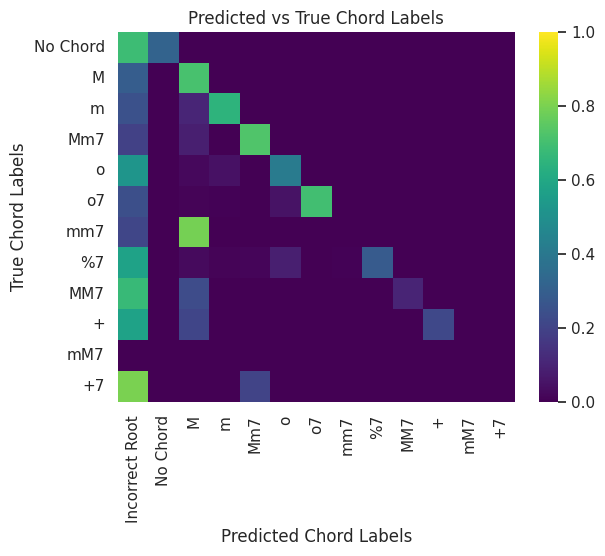

In [1794]:
chordLabelHeatMap(pivot_table)

## Correlation

In [1464]:
pred.corr()

/tmp/ipykernel_39/397320975.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pred.corr()


,accuracy,likelihood,reruns,runTime
accuracy,1.000000,0.807598,NaN,0.108337
likelihood,0.807598,1.000000,NaN,0.138667
reruns,NaN,NaN,NaN,NaN
runTime,0.108337,0.138667,NaN,1.000000


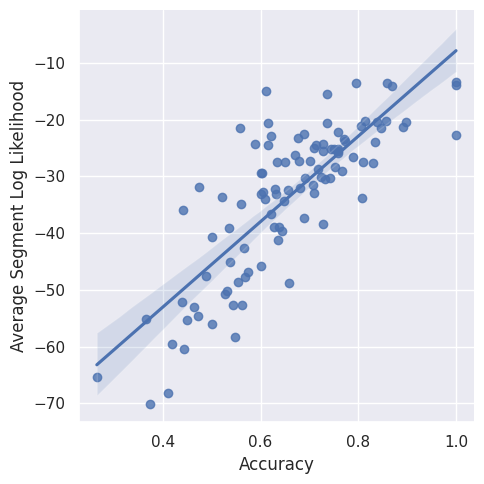

In [1471]:
#fig, ax = plt.subplots(1, 1, figsize=(9,3))

cmap = sns.color_palette("viridis", as_cmap=True)
cmap.set_bad(color="black")

axx = sns.lmplot(x='accuracy',y='likelihood', data=pred, fit_reg=True) 
#sns.scatterplot(data=pred, x="accuracy", y="likelihood")

plt.xlabel('Accuracy')
plt.ylabel('Average Segment Log Likelihood')
#a[0].set_xlabel('Beam Width')
#a[0].set_ylabel('Reservoir Size')


plt.tight_layout()
plt.savefig('plots/perfectAccuracyChordType.png', dpi=180)

## Group by algorithm for each corpus

In [1387]:
agm = pred.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).agg([np.mean, np.std])

/tmp/ipykernel_39/1476192478.py:1: FutureWarning: ['experiment'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  agm = pred.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).agg([np.mean, np.std])


In [1388]:
agm

accuracy           likelihood  \
                                            mean       std       mean   
corpus                algorithm                                         
ABC                   PerfectReduction  0.672900  0.105820 -33.500022   
chopin_mazurkas       PerfectReduction  0.706063  0.156237 -33.368881   
grieg_lyric_pieces    PerfectReduction  0.577657  0.146175 -35.697955   
schumann_kinderszenen PerfectReduction  0.773513  0.127937 -23.980487   
tests                 PerfectReduction  1.000000       NaN -13.422160   

                                                  reruns        runTime  \
                                              std   mean  std      mean   
corpus                algorithm                                           
ABC                   PerfectReduction  11.904623    1.0  0.0  0.038506   
chopin_mazurkas       PerfectReduction  15.478642    1.0  0.0  0.004740   
grieg_lyric_pieces    PerfectReduction  14.147722    1.0  0.0  0.007437   
schumann_kinderszenen PerfectReduction   6.639507    1.0  0.0  0.358893   
tests                 PerfectReduction        NaN    1.0  NaN  0.000250   

                                                  
                                             std  
corpus                algorithm                   
ABC                   PerfectReduction  0.142105  
chopin_mazurkas       PerfectReduction  0.014107  
grieg_lyric_pieces    PerfectReduction  0.018608  
schumann_kinderszenen PerfectReduction  0.717169  
tests                 PerfectReduction       NaN

## Corellation between Accuracy and Likelihood

## Analyse Accuracy By ChordType

# Test On Just a few

In [1484]:
res.loc[res["accuracy"].isna()]

accuracy chordLabels  \
id                  corpus          piece                                 
2023-04-27 14:59:42 ABC             n01op18-1_03        NaN        None   
                                    n01op18-1_03        NaN        None   
                                    n01op18-1_03        NaN        None   
                                    n01op18-1_03        NaN        None   
                                    n01op18-1_03        NaN        None   
...                                                     ...         ...   
                    chopin_mazurkas BI162-3op63-3       NaN        None   
                                    BI162-3op63-3       NaN        None   
                                    BI162-3op63-3       NaN        None   
                                    BI162-3op63-3       NaN        None   
                                    BI162-3op63-3       NaN        None   

                                                   likelihood reRuns  runTime  \
id                  corpus          piece                                       
2023-04-27 14:59:42 ABC             n01op18-1_03          NaN   None      NaN   
                                    n01op18-1_03          NaN   None      NaN   
                                    n01op18-1_03          NaN   None      NaN   
                                    n01op18-1_03          NaN   None      NaN   
                                    n01op18-1_03          NaN   None      NaN   
...                                                       ...    ...      ...   
                    chopin_mazurkas BI162-3op63-3         NaN   None      NaN   
                                    BI162-3op63-3         NaN   None      NaN   
                                    BI162-3op63-3         NaN   None      NaN   
                                    BI162-3op63-3         NaN    NaN      NaN   
                                    BI162-3op63-3         NaN    NaN      NaN   

                                                  slices  \
id                  corpus          piece                  
2023-04-27 14:59:42 ABC             n01op18-1_03    None   
                                    n01op18-1_03    None   
                                    n01op18-1_03    None   
                                    n01op18-1_03    None   
                                    n01op18-1_03    None   
...                                                  ...   
                    chopin_mazurkas BI162-3op63-3   None   
                                    BI162-3op63-3   None   
                                    BI162-3op63-3   None   
                                    BI162-3op63-3   None   
                                    BI162-3op63-3   None   

                                                                        algorithm  \
id                  corpus          piece                                           
2023-04-27 14:59:42 ABC             n01op18-1_03   DualStochasticBeamSearch_3_120   
                                    n01op18-1_03   DualStochasticBeamSearch_3_120   
                                    n01op18-1_03   DualStochasticBeamSearch_3_120   
                                    n01op18-1_03   DualStochasticBeamSearch_3_120   
                                    n01op18-1_03   DualStochasticBeamSearch_5_100   
...                                                                           ...   
                    chopin_mazurkas BI162-3op63-3   DualStochasticBeamSearch_3_70   
                                    BI162-3op63-3   DualStochasticBeamSearch_3_70   
                                    BI162-3op63-3   DualStochasticBeamSearch_3_70   
                                    BI162-3op63-3   DualStochasticBeamSearch_3_40   
                                    BI162-3op63-3   DualStochasticBeamSearch_3_40   

                                                   reruns    experiment  
id                  corpus          piece                   

# Extension accuracy Experiment

In [1508]:
(res,resg) = get_latest_experiment("extensionExp")

Getting runs of extensionExp
Parsed 524 runs succesfully, consisting of 4 unique experiments with 0 failed runs
Viewing latest result: 2023-04-27 22:12:22


In [1537]:
r = res.reset_index().groupby(["piece","algorithm"]).mean().reset_index()

/tmp/ipykernel_39/398339421.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r = res.reset_index().groupby(["piece","algorithm"]).mean().reset_index()


In [1541]:
r

,piece,algorithm,accuracy,likelihood,runTime,reruns
0,BI105-3op30-3,DualStochasticBeamSearch_11_100,NaN,NaN,NaN,NaN
1,BI105-3op30-3,DualStochasticBeamSearch_15_100,NaN,NaN,NaN,NaN
2,BI105-3op30-3,DualStochasticBeamSearch_3_130,NaN,NaN,NaN,NaN
3,BI105-3op30-3,DualStochasticBeamSearch_3_200,NaN,NaN,NaN,NaN
4,BI105-3op30-3,DualStochasticBeamSearch_5_100,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
219,op71n07,DualStochasticBeamSearch_3_130,0.432432,-12.920722,588.110288,1.0
220,op71n07,DualStochasticBeamSearch_3_200,NaN,NaN,NaN,NaN
221,op71n07,DualStochasticBeamSearch_5_100,0.445946,-12.896551,605.906417,1.0
222,op71n07,DualStochasticBeamSearch_7_100,NaN,NaN,NaN,NaN


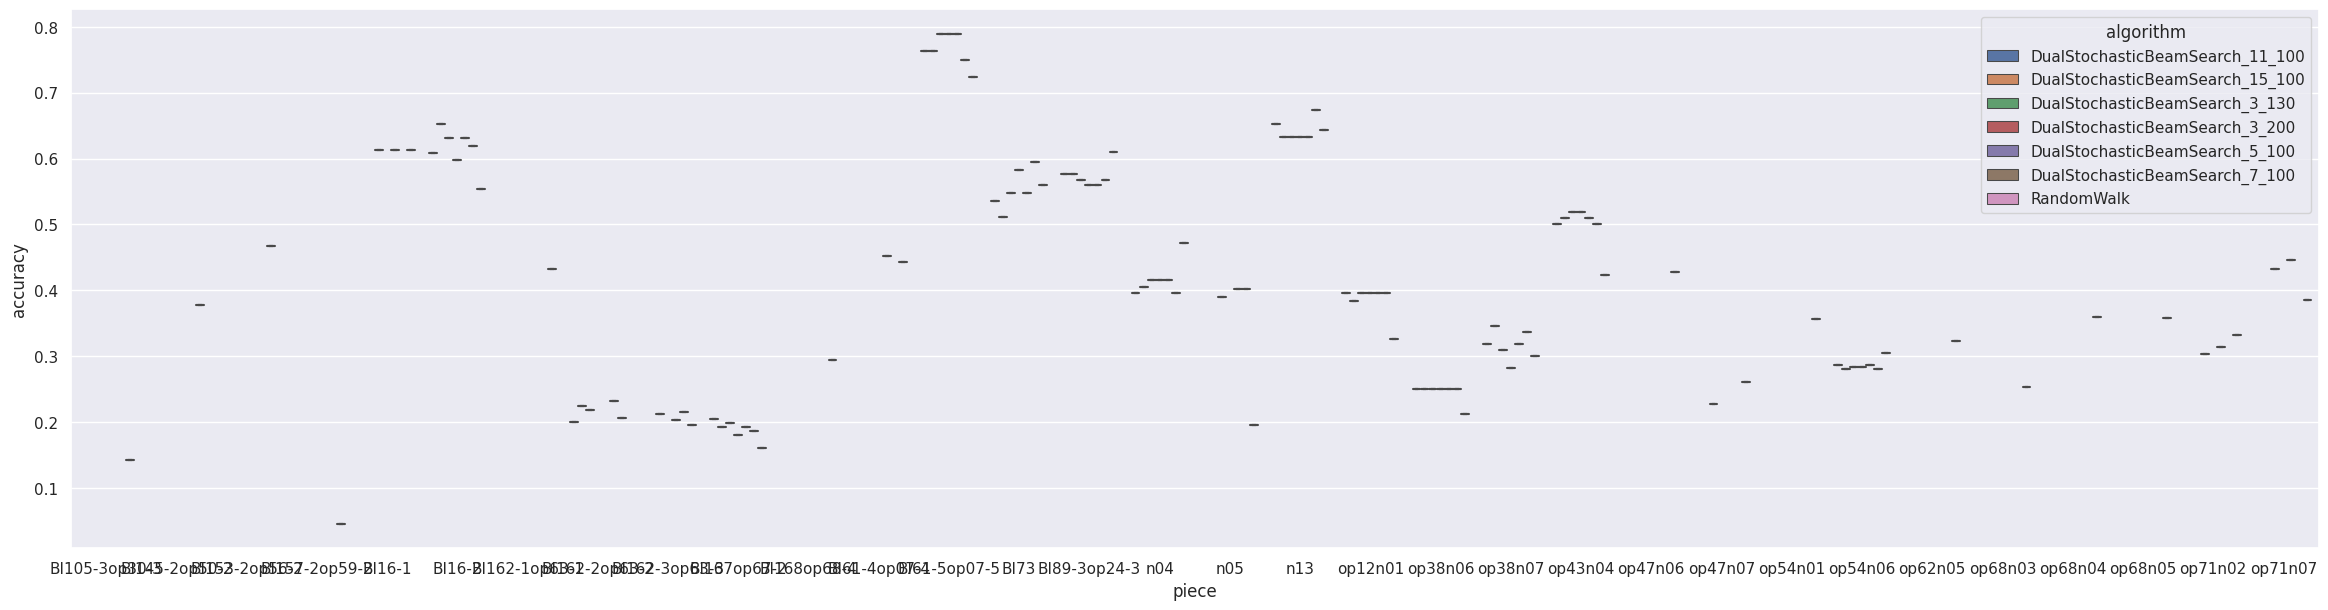

In [1540]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(29,7))

g = sns.boxplot( x='piece', y='accuracy',hue='algorithm', data=r.reset_index())

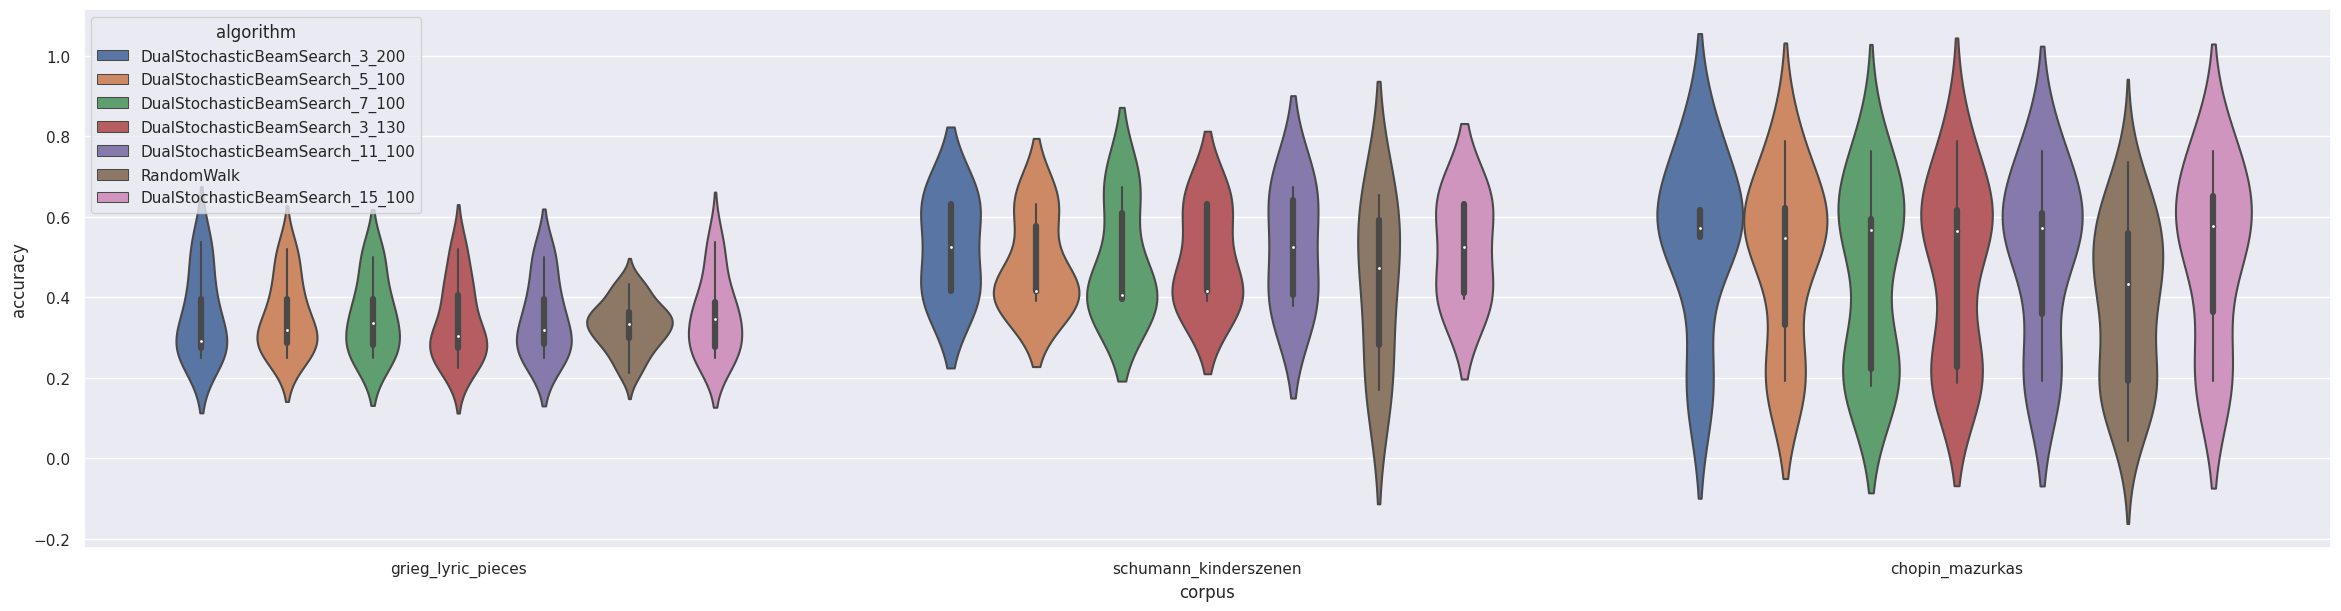

In [1544]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(29,7))

f = sns.violinplot( x='corpus', y='accuracy',hue='algorithm', data=res.reset_index())


In [1512]:
res.to_csv("smth.csv")

# Random walk all pieces
Let's look at all experiments that have been run

In [1390]:
(results, groundTruth) = get_experiments("parseable")

Getting runs of extensionExp
Parsed 69 runs succesfully, consisting of 1 unique experiments with 1 failed runs


In [1393]:
results.loc[results["accuracy"].notna()].to_csv("resres.csv")

In [1133]:
results

accuracy  \
id                  corpus          piece                     
2023-04-26 07:56:36 ABC             n07op59-1_03        NaN   
                                    n07op59-1_03        NaN   
                                    n13op130_06         NaN   
                                    n13op130_06         NaN   
                                    n06op18-6_02        NaN   
...                                                     ...   
                    chopin_mazurkas BI162-3op63-3  0.195122   
                                    BI89-4op24-4        NaN   
                                    BI89-4op24-4        NaN   
2023-04-25 21:56:09 chopin_mazurkas BI89-4op24-4        NaN   
                                    BI89-4op24-4        NaN   

                                                                                         chordLabels  \
id                  corpus          piece                                                              
2023-04-26 07:56:36 ABC             n07op59-1_03                                                None   
                                    n07op59-1_03                                                None   
                                    n13op130_06                                                 None   
                                    n13op130_06                                                 None   
                                    n06op18-6_02                                                None   
...                                                                                              ...   
                    chopin_mazurkas BI162-3op63-3  [AM, C♯M, G♯M, G♯Mm7, D♯Mm7, C♯m, D♯Mm7, G♯Mm7...   
                                    BI89-4op24-4                                                None   
                                    BI89-4op24-4                                                None   
2023-04-25 21:56:09 chopin_mazurkas BI89-4op24-4                                                None   
                                    BI89-4op24-4                                                None   

                                                   likelihood reRuns  runTime  \
id                  corpus          piece                                       
2023-04-26 07:56:36 ABC             n07op59-1_03          NaN   None      NaN   
                                    n07op59-1_03          NaN   None      NaN   
                                    n13op130_06           NaN   None      NaN   
                                    n13op130_06           NaN   None      NaN   
                                    n06op18-6_02          NaN   None      NaN   
...                                                       ...    ...      ...   
                    chopin_mazurkas BI162-3op63-3  -12.564073    NaN  0.86659   
                                    BI89-4op24-4          NaN    NaN      NaN   
                                    BI89-4op24-4          NaN    NaN      NaN   
2023-04-25 21:56:09 chopin_mazurkas BI89-4op24-4          NaN    NaN      NaN   
                                    BI89-4op24-4          NaN    NaN      NaN   

                                                                                              slices  \
id                  corpus          piece                                                              
2023-04-26 07:56:36 ABC             n07op59-1_03                                                None   
                                    n07op59-1_03                                                None   
                                    n13op130_06                                                 None   
                                    n13op130_06                                                 None   
                                    n06op18-6_02                                                None   
...                                                                                             

In [1128]:
(results,pg) = get_latest_experiment("parseable")

Getting runs of parseable
Parsed 239 runs succesfully, consisting of 3 unique experiments with 129 failed runs
Viewing latest result: 2023-04-26 19:10:39


In [1134]:
results.to_csv("test.csv")

## Number of Pieces in Total

In [1180]:
results.reset_index()["piece"].nunique()

174

## Number of Pieces that failed to parse

In [1181]:
results.loc[results.accuracy.isna()].reset_index()["piece"].nunique()

120

In [1161]:
succ = results.loc[results.accuracy.notna()].reset_index().drop_duplicates(subset=["piece"]).sort_values(by="runTime")

## Number of Pieces that parsed succesfully

In [1186]:
succ["piece"].nunique()

60

In [1162]:
succ.corr()

/tmp/ipykernel_39/1619751041.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  succ.corr()


,accuracy,likelihood,runTime,reruns
accuracy,1.000000,0.112586,0.079203,-0.255081
likelihood,0.112586,1.000000,-0.066200,0.065976
runTime,0.079203,-0.066200,1.000000,-0.099199
reruns,-0.255081,0.065976,-0.099199,1.000000


In [1168]:
succ[["corpus","piece"]].to_csv("successful parses.csv")

In [1169]:
s = succ[["corpus","piece"]]

In [1174]:
pairs = list(map(tuple, s[['corpus', 'piece']].values.tolist()))

In [1176]:
#pairs

In [1178]:
#s.values.tolist()

In [1163]:
succ = succ.head(150)

In [1158]:
succg = succ.groupby(["corpus", "algorithm"])

# Baseline Experiments

In [1776]:
(res,gt) = get_latest_experiment("baselineExp")

Getting runs of baselineExp
Parsed 529 runs succesfully, consisting of 4 unique experiments with 25 failed runs
Viewing latest result: 2023-04-27 12:33:45


In [1777]:
res = res.reset_index()

In [1778]:
res

,id,corpus,piece,accuracy,chordLabels,likelihood,reRuns,runTime,slices,reruns,algorithm,experiment
0,2023-04-27 12:33:45,ABC,n01op18-1_03,0.497537,"[FM, FM, CM, CM, FM, Gm, B♭M, DM, DM, EMm7, Am...",-14.737749,NaN,0.061777,"[[F3, F5, C5, C5, A4], [F5, C5, C5, A3, A3], [...",1.0,RandomReduction,baselineExp
1,2023-04-27 12:33:45,ABC,n01op18-1_03,0.458128,"[FM, Am, CM, CM, DMm7, Gm, B♭M, DM, DM, EM, Am...",-15.157059,NaN,0.002775,"[[F3, C5, A4, A4, A4], [C5, C5, A4, A4, A4], [...",1.0,RandomReduction,baselineExp
2,2023-04-27 12:33:45,ABC,n01op18-1_03,0.477833,"[FM, B♭M, GMm7, CM, DMm7, Gm, CMm7, DM, DM, EM...",-14.599278,NaN,0.016300,"[[F3, F3, C5], [C5, B♭3, B♭3, A3], [F5, G4, G4...",1.0,RandomReduction,baselineExp
3,2023-04-27 12:33:45,ABC,n01op18-1_03,0.487685,"[FM, FM, FM, CM, DM, Gm, Gm, GM, DM, EMm7, Am,...",-14.752708,NaN,0.000929,"[[F5, F5, C5, C5, A4, A4], [F5, F5, C5, B♭3], ...",1.0,RandomReduction,baselineExp
4,2023-04-27 12:33:45,ABC,n01op18-1_03,0.610837,"[FM, FM, CM, CM, DM, Gm, Gm, DM, DM, EM, Am, A...",-13.358424,NaN,102.702083,"[[F3, F5, C5, A4], [F5, C5, A3, A4], [F5, C5, ...",1.0,RandomWalkPerSegment,baselineExp
...,...,...,...,...,...,...,...,...,...,...,...,...
751,2023-04-27 12:33:45,chopin_mazurkas,BI162-3op63-3,0.195122,"[AM, C♯m, D♯Mm7, G♯Mm7, C♯m, EM, D♯Mm7, G♯Mm7,...",-12.305455,NaN,0.385657,"[[E5, A5], [E5, C♯5, C♯6, G♯4], [C♯6, D♯4], [D...",1.0,RandomWalk,baselineExp
752,2023-04-27 12:33:45,chopin_mazurkas,BI162-3op63-3,0.471545,"[EM, C♯m, G♯Mm7, G♯Mm7, C♯m, C♯m, D♯Mm7, G♯Mm7...",-54.669376,NaN,0.000344,"[[E5], [E5, E5, E5, C♯4, C♯5, C♯5, C♯5, C♯6, C...",1.0,PerfectReduction,baselineExp
753,2023-04-27 12:33:45,chopin_mazurkas,BI162-3op63-3,0.471545,"[EM, C♯m, G♯Mm7, G♯Mm7, C♯m, C♯m, D♯Mm7, G♯Mm7...",-54.669376,NaN,0.000097,"[[E5], [E5, E5, E5, C♯4, C♯5, C♯5, C♯5, C♯6, C...",1.0,PerfectReduction,baselineExp
754,2023-04-27 12:33:45,chopin_mazurkas,BI162-3op63-3,0.471545,"[EM, C♯m, G♯Mm7, G♯Mm7, C♯m, C♯m, D♯Mm7, G♯Mm7...",-54.669376,NaN,0.000068,"[[E5], [E5, E5, E5, C♯4, C♯5, C♯5, C♯5, C♯6, C...",1.0,PerfectReduction,baselineExp


In [1786]:
r = res.groupby(["algorithm","corpus"]).mean().reset_index()

/tmp/ipykernel_39/1931972330.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r = res.groupby(["algorithm","corpus"]).mean().reset_index()


In [1787]:
r

,algorithm,corpus,accuracy,likelihood,reRuns,runTime,reruns
0,PerfectReduction,ABC,0.637014,-37.101096,NaN,0.002177,1.000000
1,PerfectReduction,chopin_mazurkas,0.718384,-30.558662,NaN,0.027519,1.000000
2,PerfectReduction,grieg_lyric_pieces,0.579164,-31.817224,NaN,0.029796,1.000000
3,PerfectReduction,schumann_kinderszenen,0.734249,-24.880247,NaN,0.000213,1.000000
4,RandomReduction,ABC,0.399963,-14.644274,NaN,0.012706,1.000000
5,RandomReduction,chopin_mazurkas,0.415308,-14.791491,NaN,0.035546,1.000000
6,RandomReduction,grieg_lyric_pieces,0.305618,-14.947310,NaN,0.056844,1.000000
7,RandomReduction,schumann_kinderszenen,0.433000,-14.225545,NaN,0.096444,1.000000
8,RandomSample,ABC,0.015090,-15.693249,NaN,0.000091,1.000000
9,RandomSample,chopin_mazurkas,0.017958,-15.608477,NaN,0.000560,1.000000


In [1788]:
r

,algorithm,corpus,accuracy,likelihood,reRuns,runTime,reruns
0,PerfectReduction,ABC,0.637014,-37.101096,NaN,0.002177,1.000000
1,PerfectReduction,chopin_mazurkas,0.718384,-30.558662,NaN,0.027519,1.000000
2,PerfectReduction,grieg_lyric_pieces,0.579164,-31.817224,NaN,0.029796,1.000000
3,PerfectReduction,schumann_kinderszenen,0.734249,-24.880247,NaN,0.000213,1.000000
4,RandomReduction,ABC,0.399963,-14.644274,NaN,0.012706,1.000000
5,RandomReduction,chopin_mazurkas,0.415308,-14.791491,NaN,0.035546,1.000000
6,RandomReduction,grieg_lyric_pieces,0.305618,-14.947310,NaN,0.056844,1.000000
7,RandomReduction,schumann_kinderszenen,0.433000,-14.225545,NaN,0.096444,1.000000
8,RandomSample,ABC,0.015090,-15.693249,NaN,0.000091,1.000000
9,RandomSample,chopin_mazurkas,0.017958,-15.608477,NaN,0.000560,1.000000


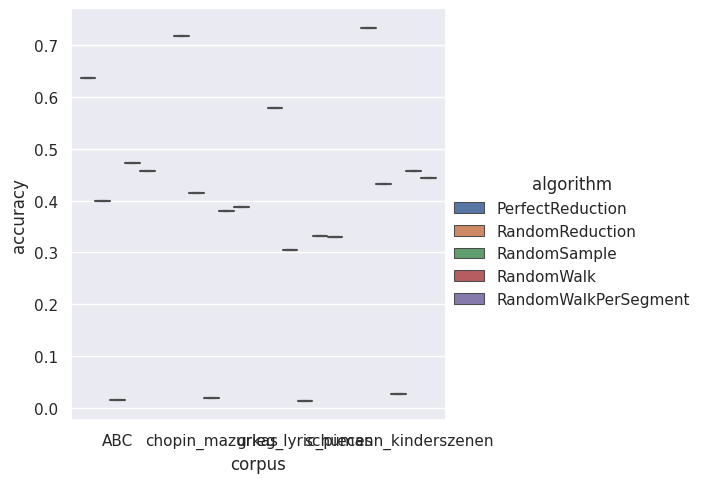

In [1789]:
sns.catplot(x='corpus', y='accuracy',hue='algorithm', data=r, kind='box')

In [1755]:
acc_std_pivot = pd.pivot_table(res, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.std)
lik_std_pivot = pd.pivot_table(res, 
                          values="likelihood", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.std)
acc_pivot = pd.pivot_table(res, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.mean)
lik_pivot = pd.pivot_table(res, 
                          values="likelihood", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.mean)

In [1407]:
r = res.reset_index()

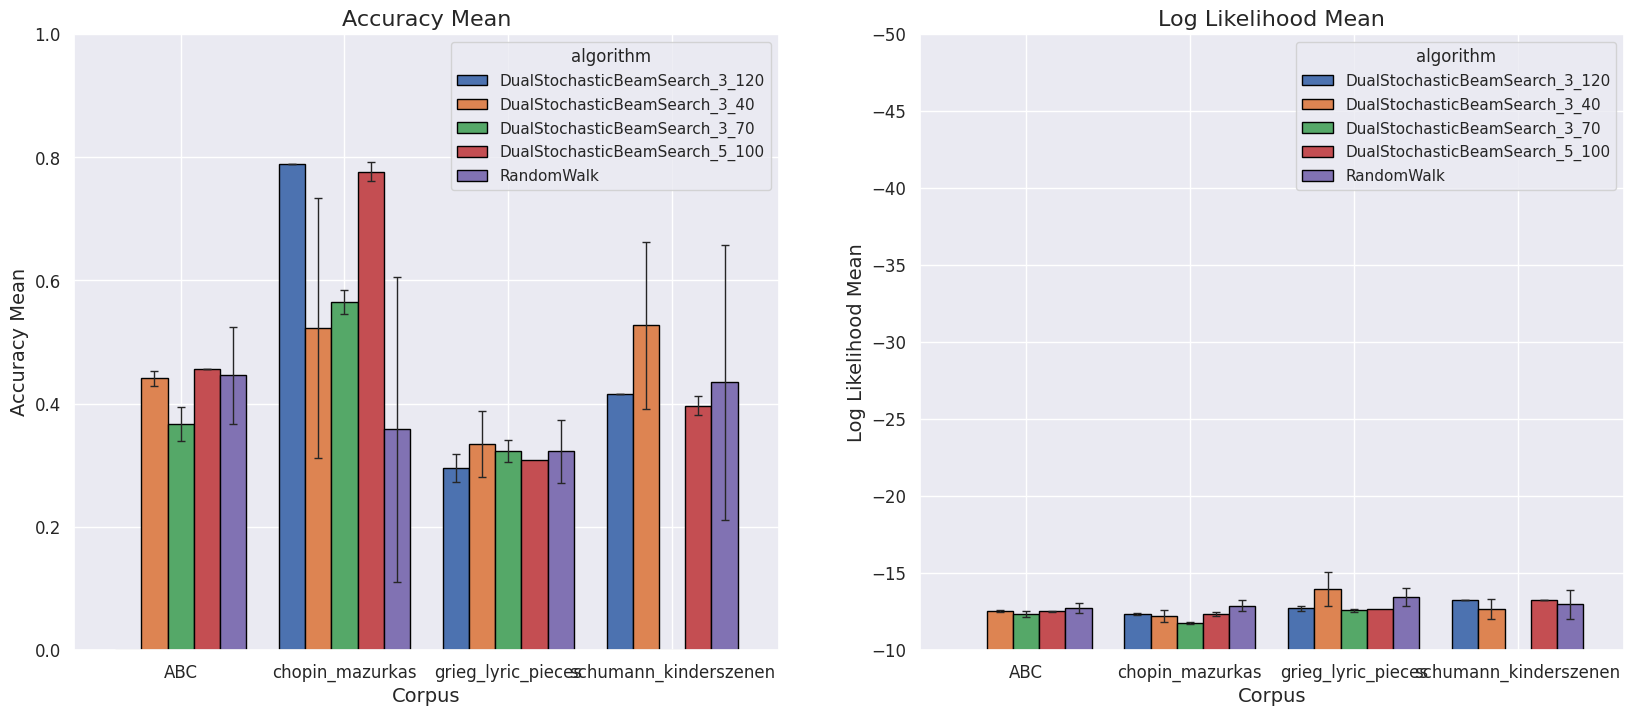

In [1401]:
# Create two subplots side by side
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.set()  # use Seaborn styles

# First plot for accuracy_mean
axs[0].set_title('Accuracy Mean', fontsize=16)
acc_pivot.plot.bar(ax=axs[0], yerr=acc_std_pivot, fontsize=12, rot=0, ylim=(0,1), width=0.8, edgecolor='black', capsize=5, error_kw=dict(lw=1, capsize=3, capthick=1), legend="loc:lower center")
axs[0].set_xlabel("Corpus", fontsize=14)
axs[0].set_ylabel("Accuracy Mean", fontsize=14)

# Second plot for likelihood_mean
axs[1].set_title('Log Likelihood Mean', fontsize=16)
lik_pivot.plot.bar(ax=axs[1], yerr=lik_std_pivot, fontsize=12, rot=0, ylim=(-10,-50), width=0.8, edgecolor='black', capsize=5, error_kw=dict(lw=1, capsize=3, capthick=1), legend="loc:lower center")
axs[1].set_xlabel("Corpus", fontsize=14)
axs[1].set_ylabel("Log Likelihood Mean", fontsize=14)

plt.savefig("plots/baselineResults",dpi=180)


In [1366]:
res.loc[res["accuracy"].notna()].head()

accuracy  likelihood  \
id                  corpus          piece                                 
2023-04-27 12:33:45 ABC             n01op18-1_03   0.497537  -14.737749   
                                    n01op18-1_03   0.458128  -15.157059   
                                    n01op18-1_03   0.477833  -14.599278   
                                    n01op18-1_03   0.487685  -14.752708   
                                    n01op18-1_03   0.610837  -13.358424   
...                                                     ...         ...   
                    chopin_mazurkas BI162-3op63-3  0.195122  -12.305455   
                                    BI162-3op63-3  0.471545  -54.669376   
                                    BI162-3op63-3  0.471545  -54.669376   
                                    BI162-3op63-3  0.471545  -54.669376   
                                    BI162-3op63-3  0.471545  -54.669376   

                                                              algorithm  
id                  corpus          piece                                
2023-04-27 12:33:45 ABC             n01op18-1_03        RandomReduction  
                                    n01op18-1_03        RandomReduction  
                                    n01op18-1_03        RandomReduction  
                                    n01op18-1_03        RandomReduction  
                                    n01op18-1_03   RandomWalkPerSegment  
...                                                                 ...  
                    chopin_mazurkas BI162-3op63-3            RandomWalk  
                                    BI162-3op63-3      PerfectReduction  
                                    BI162-3op63-3      PerfectReduction  
                                    BI162-3op63-3      PerfectReduction  
                                    BI162-3op63-3      PerfectReduction  

[750 rows x 3 columns]

In [1103]:
#parsed

In [1088]:
r = {"grieg_lyric_pieces": ["op12n01","op38n07", "op47n04", "op71n03", "op54n06"]
        ,"chopin_mazurkas": ["BI168op68-4", "BI89-3op24-3"]
        ,"schumann_kinderszenen": ["n03", "n04", "n13"]
        ,"ABC": ["n14op131_06", "n14op131_03"]}

In [1089]:
pairs= []
for corpus in r.keys():
    for piece in r[corpus]:
        pairs.append((corpus,piece))

In [1090]:
pairs

[('grieg_lyric_pieces', 'op12n01'),
 ('grieg_lyric_pieces', 'op38n07'),
 ('grieg_lyric_pieces', 'op47n04'),
 ('grieg_lyric_pieces', 'op71n03'),
 ('grieg_lyric_pieces', 'op54n06'),
 ('chopin_mazurkas', 'BI168op68-4'),
 ('chopin_mazurkas', 'BI89-3op24-3'),
 ('schumann_kinderszenen', 'n03'),
 ('schumann_kinderszenen', 'n04'),
 ('schumann_kinderszenen', 'n13'),
 ('ABC', 'n14op131_06'),
 ('ABC', 'n14op131_03')]

In [1091]:
a = parsed.reset_index()

In [1092]:
#a.sort_values(by=["runTime"]).head(50)[["corpus","piece","accuracy","runTime"]]

In [1093]:
a.piece.unique()

array(['n04op18-4_03', 'op38n02', 'op47n04', 'op54n06', 'n04',
       'BI167op67-2', 'BI61-4op07-4'], dtype=object)

In [1094]:
(ppr,ppg) = get_latest_experiment("exp")

Getting runs of exp
Parsed 1415 runs succesfully, consisting of 11 unique experiments with 277 failed runs
Viewing latest result: 2023-04-26 19:11:22


In [1054]:
ppr = ppr.loc[ppr.accuracy.notna()]

In [1055]:
ppr

accuracy  \
id                  corpus          piece                   
2023-04-26 19:11:22 ABC             n14op131_03  0.300000   
                                    n14op131_03  0.266667   
                                    n14op131_03  0.366667   
                                    n14op131_03  0.433333   
                                    n14op131_03  0.500000   
...                                                   ...   
                    chopin_mazurkas BI168op68-4  0.237500   
                                    BI168op68-4  0.300000   
                                    BI168op68-4  0.600000   
                                    BI168op68-4  0.600000   
                                    BI168op68-4  0.600000   

                                                                                       chordLabels  \
id                  corpus          piece                                                            
2023-04-26 19:11:22 ABC             n14op131_03  [BM, F♯M, F♯M, DMM7, GM, C♯m, DM, BM, Bm, F♯M,...   
                                    n14op131_03  [DM, F♯M, G♯mm7, DM, GM, F♯Mm7, DM, DM, Bm, F♯...   
                                    n14op131_03  [BM, F♯M, F♯M, F♯Mm7, Emm7, F♯M, DM, Bm, Bm, F...   
                                    n14op131_03  [Bm, F♯M, F♯M, AM, CM, F♯M, DM, Bm, Bm, A♯M, B...   
                                    n14op131_03  [Bm, F♯M, F♯M, C♯M, CM, C♯M, DM, Bm, Bm, F♯M, ...   
...                                                                                            ...   
                    chopin_mazurkas BI168op68-4  [D♭M, BM, G%7, G♭Mm7, Co, AM, F%7, A♭M, EMm7, ...   
                                    BI168op68-4  [D♭M, A♯M, G%7, B♭M, Co, AM, F%7, A♭M, EMm7, G...   
                                    BI168op68-4  [Fm, GMm7, G%7, C♯♯M, Co, FMm7, F%7, Bo7, EMm7...   
                                    BI168op68-4  [Fm, GMm7, G%7, C♯♯M, Co, FMm7, F%7, Bo7, EMm7...   
                                    BI168op68-4  [Fm, GMm7, G%7, C♯♯M, Co, FMm7, F%7, Bo7, EMm7...   

                                                 likelihood reRuns   runTime  \
id                  corpus          piece                                      
2023-04-26 19:11:22 ABC             n14op131_03  -14.922988    NaN  0.001669   
                                    n14op131_03  -14.643136    NaN  0.000526   
                                    n14op131_03  -14.685332    NaN  0.265464   
                                    n14op131_03  -12.522228    NaN  6.953372   
                                    n14op131_03  -12.140713    NaN  0.115784   
...                                                     ...    ...       ...   
                    chopin_mazurkas BI168op68-4  -12.740737    NaN  0.102770   
                                    BI168op68-4  -12.574789    NaN  0.122034   
                                    BI168op68-4  -29.355344    NaN  0.000498   
                                    BI168op68-4  -29.355344    NaN  0.000125   
                                    BI168op68-4  -29.355344    NaN  0.000106   

                                                                                            slices  \
id                  corpus          piece                                                            
2023-04-26 19:11:22 ABC             n14op131_03  [[B4, F♯5, F♯5, F♯5], [C♯5, C♯5, C♯5, C♯5, C♯5...   
                                    n14op131_03  [[D5, F♯5, F♯5, F♯5, F♯5, F♯5], [C♯5, C♯6, A♯4...   
                                    n14op131_03  [[B4, F♯5, F♯5, F♯5], [C♯5, C♯6, C♯6, C♯6, C♯6...   
                                    n14op131_03  [[D5, B4, F♯5, F♯5], [C♯5, C♯6, A♯4, F♯5], [A♯...   
                                    n14op131_03  [[D5, B4, F♯5, F♯5], [C♯5, C♯6, A♯4, F♯5], [A♯...   
...                                                                                            ...   
                    chopin_mazurkas BI168op68-4  [[D♭6, F5, C5, A♭4], [

In [1063]:
ppr.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).count()

accuracy  likelihood  \
corpus                algorithm                                              
ABC                   PerfectReduction                       9           9   
                      RandomReduction                        9           9   
                      RandomSample                           9           9   
                      RandomWalk                             9           9   
                      RandomWalkPerSegment                   9           9   
chopin_mazurkas       PerfectReduction                       9           9   
                      RandomReduction                        9           9   
                      RandomSample                           9           9   
                      RandomWalk                             9           9   
                      RandomWalkPerSegment                   9           9   
grieg_lyric_pieces    PerfectReduction                      12          12   
                      RandomReduction                       12          12   
                      RandomSample                          15          15   
                      RandomWalk                            15          15   
                      RandomWalkPerSegment                  15          15   
schumann_kinderszenen DualStochasticBeamSearch_10_50         2           2   
                      DualStochasticBeamSearch_5_50          4           4   
                      PerfectReduction                       6           6   
                      RandomReduction                        6           6   
                      RandomSample                           9           9   
                      RandomWalk                             9           9   
                      RandomWalkPerSegment                   9           9   

                                                      reRuns  runTime  reruns  \
corpus                algorithm                                                 
ABC                   PerfectReduction                     0        9       9   
                      RandomReduction                      0        9       9   
                      RandomSample                         0        9       9   
                      RandomWalk                           0        9       9   
                      RandomWalkPerSegment                 0        9       9   
chopin_mazurkas       PerfectReduction                     0        9       9   
                      RandomReduction                      0        9       9   
                      RandomSample                         0        9       9   
                      RandomWalk                           0        9       9   
                      RandomWalkPerSegment                 0        9       9   
grieg_lyric_pieces    PerfectReduction                     0       12      12   
                      RandomReduction                      0       12      12   
                      RandomSample                         0       15      15   
                      RandomWalk                           0       15      15   
                      RandomWalkPerSegment                 0       15      15   
schumann_kinderszenen DualStochasticBeamSearch_10_50       0        2       2   
                      DualStochasticBeamSearch_5_50        0        4       4   
                      PerfectReduction                     0        6       6   
                      RandomReduction                      0        6       6   
                      RandomSample                         0        9       9   
                      RandomWalk                           0        9       9   
                      RandomWalkPerSegment                 0        9       9   

                                                      experiment  
corpus                algorithm                                   
ABC                   PerfectReduction                         9  
                      RandomReducti

In [1072]:
agm = ppr.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm","piece"]).agg([np.mean])
#agm2 = agm.groupby(["corpus","algorithm"]).agg(np.mean)
#errs = agm.reset_index()["accuracy"]["std"].fillna(0)
#a = results.drop(["chordLabels", "slices"], axis=1)
#std_pivot = pd.pivot_table(agm, 
#                          values="accuracy", 
#                          index="corpus", 
#                          columns="algorithm", 
#                          aggfunc=np.std)
acc_pivot = pd.pivot_table(agm, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.mean)
lik_pivot = pd.pivot_table(agm, 
                          values="likelihood", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.mean)

/tmp/ipykernel_39/4230411235.py:1: FutureWarning: ['experiment'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  agm = ppr.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm","piece"]).agg([np.mean])


## Plot Accuracy Chart

In [1073]:
ratio = 1
height = 5

In [1074]:
lik_pivot.max().max()

-12.484929130318292

In [1075]:
lik_pivot


mean  \
algorithm             DualStochasticBeamSearch_10_50   
corpus                                                 
ABC                                              NaN   
chopin_mazurkas                                  NaN   
grieg_lyric_pieces                               NaN   
schumann_kinderszenen                     -13.224811   

                                                                      \
algorithm             DualStochasticBeamSearch_5_50 PerfectReduction   
corpus                                                                 
ABC                                             NaN       -34.276956   
chopin_mazurkas                                 NaN       -21.458989   
grieg_lyric_pieces                              NaN       -29.745105   
schumann_kinderszenen                    -12.812294       -20.362157   

                                                               \
algorithm             RandomReduction RandomSample RandomWalk   
corpus                                                          
ABC                        -14.479785   -15.680401 -12.525615   
chopin_mazurkas            -14.748150   -15.261256 -12.996111   
grieg_lyric_pieces         -15.694955   -15.551111 -13.941524   
schumann_kinderszenen      -14.403342   -15.549754 -12.907969   

                                            
algorithm             RandomWalkPerSegment  
corpus                                      
ABC                             -12.484929  
chopin_mazurkas                 -12.994274  
grieg_lyric_pieces              -14.000329  
schumann_kinderszenen           -12.945998

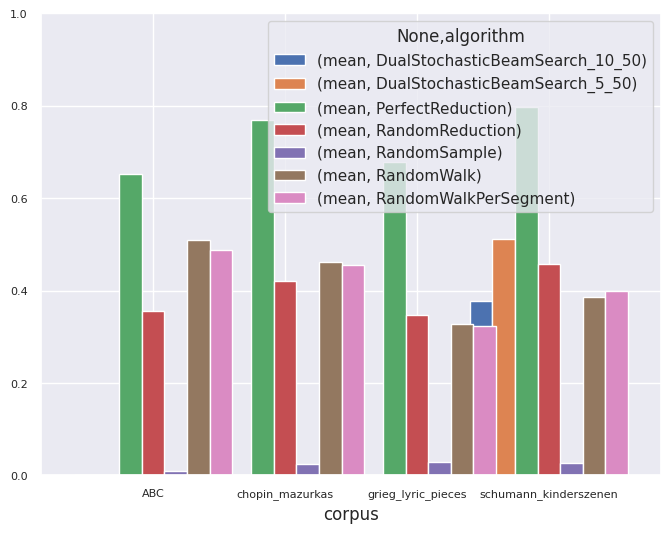

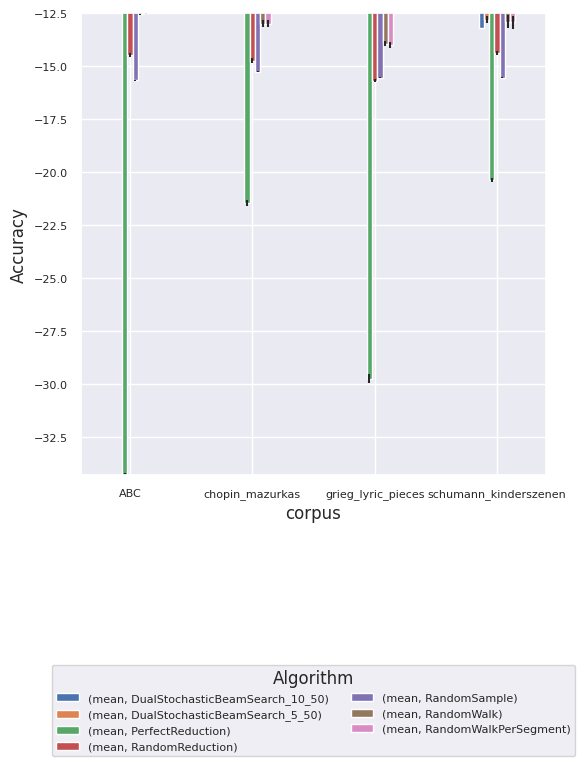

In [1076]:
#fig, ax = plt.subplots(1, 2, figsize=((height*2)/ratio+ spacing,height),gridspec_kw={'width_ratios': [1,1]})
#lik_avgs.min().min(), lik_avgs.max().max()+ (lik_avgs.max().max()-lik_avgs.min().min()

sns.set()  # use Seaborn styles
#acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,2), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
r = acc_pivot.plot.bar( figsize=(8,6), fontsize=8, rot=0, ylim=(0,1), width=1.2, legend="loc:lower center")
l = lik_pivot.plot.bar(yerr=std_pivot,  figsize=(6,6), fontsize=8, rot=0, ylim=(lik_pivot.min().min(),lik_pivot.max().max()), width=0.3, legend="loc:lower center")

plt.ylabel('Accuracy')
plt.legend(loc='upper center', title="Algorithm", bbox_to_anchor=(0.5, -0.4),
          fancybox=True, ncol=2, prop={'size': 8})
          

# Extention: Dual Stochastic Beam Search Parameters

## Run time experiments

 Extract parameters from algorithm name

In [1691]:
(resultsb, labels) = get_latest_experiment("extensionBeamwidth")
resultsb = resultsb.reset_index()
resultsb['beamwidth'] = resultsb["algorithm"].apply(lambda s: int(s.split("_")[1]))
resultsb['reservoirsize'] = resultsb["algorithm"].apply(lambda s: int(s.split("_")[2]))

Getting runs of extensionBeamwidth
Parsed 52 runs succesfully, consisting of 1 unique experiments with 0 failed runs
Viewing latest result: 2023-04-28 18:31:22


In [1700]:
(resultsr, labels) = get_latest_experiment("extensionReservoir")
resultsr['beamwidth'] = resultsr["algorithm"].apply(lambda s: int(s.split("_")[1]))
resultsr['reservoirsize'] = resultsr["algorithm"].apply(lambda s: int(s.split("_")[2]))

Getting runs of extensionReservoir
Parsed 80 runs succesfully, consisting of 1 unique experiments with 0 failed runs
Viewing latest result: 2023-04-28 17:02:14


In [1726]:
(results, labels) = get_latest_experiment("extensionParams")

Getting runs of extensionParams
Parsed 277 runs succesfully, consisting of 2 unique experiments with 0 failed runs
Viewing latest result: 2023-04-28 14:23:14


In [1744]:
resultsc = pd.concat([resultsr,resultsb,results])

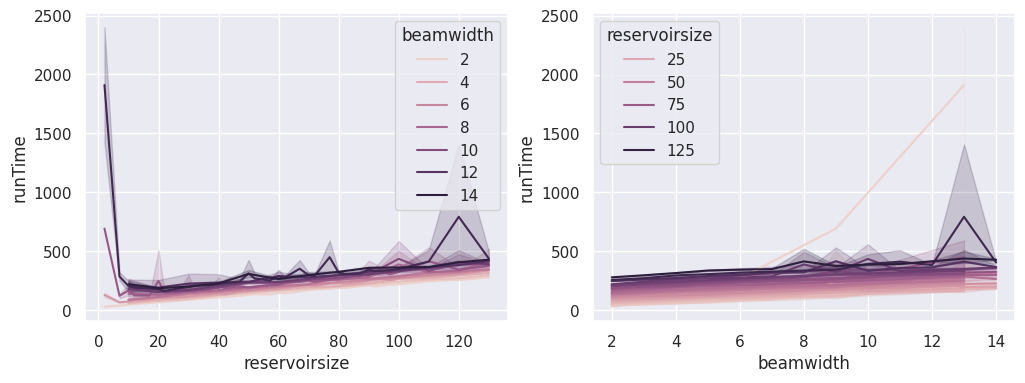

In [1745]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

sns.lineplot(ax = ax[0], data=resultsc.reset_index(), x="reservoirsize",y="runTime", hue="beamwidth")
sns.lineplot(ax = ax[1], data=resultsc.reset_index(), x="beamwidth",y="runTime", hue="reservoirsize")
#sns.violinplot(ax = ax[2], data=results.reset_index(), x="beamwidth",y="accuracy", hue="reservoirsize")


plt.show()

## Accuracy, loglikelihood and runtime

In [1639]:
exp_id = results.index.get_level_values(0)[0].strftime('%Y%m%d%H%M%S')

## Plot hyperparemter results

In [1651]:
def create_heatmap(xs, ax, vmin, vmax,cmap):
    lbls = xs.applymap(lambda v: "{:.2f}".format(v) if v in [np.nanmax(xs.values),np.nanmin(xs.values)]else '')
    return sns.heatmap(xs,
            square=True,
            ax=ax,
            cmap=cmap,
            fmt='',
            annot=lbls, # Label the maximum value
            annot_kws={'fontsize':5},
            mask=xs.isna(),
            vmax=vmax,
            vmin=vmin,
            linewidth=0.01)

In [1728]:
results.corr()

/tmp/ipykernel_39/3798538541.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  results.corr()


,accuracy,likelihood,reruns,runTime,reRuns
accuracy,1.000000,-0.395675,NaN,-0.080502,NaN
likelihood,-0.395675,1.000000,NaN,0.139348,NaN
reruns,NaN,NaN,NaN,NaN,NaN
runTime,-0.080502,0.139348,NaN,1.000000,NaN
reRuns,NaN,NaN,NaN,NaN,NaN


In [1731]:
results['beamwidth'] = results["algorithm"].apply(lambda s: int(s.split("_")[1]))
results['reservoirsize'] = results["algorithm"].apply(lambda s: int(s.split("_")[2]))

def get_avgs(df, value):
    g = df.dropna(subset=value).groupby(['beamwidth','reservoirsize'])
    df_means = g[value].mean()
    return df_means.loc[:,:].reset_index().pivot(index='reservoirsize', columns='beamwidth', values=value)

acc_avgs = get_avgs(results, 'accuracy')
lik_avgs = get_avgs(results, 'likelihood')
lik_avgs = np.exp(lik_avgs)
run_avgs = get_avgs(results, 'runTime')

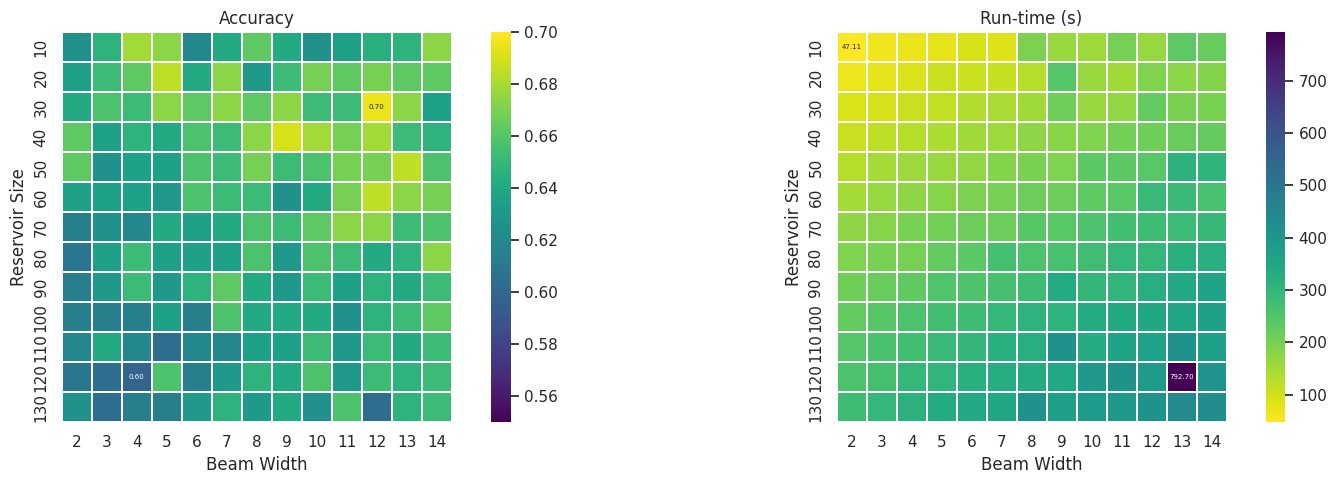

In [1753]:
height=5
ratio = results['reservoirsize'].nunique() / results['beamwidth'].nunique()
spacing = 1
fig, ax = plt.subplots(1, 2, figsize=((height*3)/ratio+ spacing,height),gridspec_kw={'width_ratios': [1,1]})

cmap = sns.color_palette("viridis", as_cmap=True)
# Set minimum and maximum values for logarithmic colormap
#vmin = -0.6
#vmax = -0.5
cmap.set_bad(color="black")

#l = create_heatmap(lik_avgs, ax[0],  lik_avgs.min().min(),lik_avgs.max().max(),cmap.reversed())
a = create_heatmap(acc_avgs, ax[0], 0.55, 0.7, cmap)
r = create_heatmap(run_avgs, ax[1], run_avgs.min().min(), run_avgs.max().max(), cmap.reversed())

#ax[0].set_title('Likelihood')
#ax[0].invert_yaxis()
ax[0].set_title('Accuracy')
ax[1].set_title('Run-time (s)')

for a in ax:
    a.set_xlabel('Beam Width')
    a.set_ylabel('Reservoir Size')


plt.tight_layout()
plt.savefig('plots/dualstochbeamsearchgridsearch2.png', dpi=180)

# Heuristic Search vs baseline

### Choose specific experiement
202304-1700-0801 is the first experiment ran.
Includes 795 total runs. 
With Beam width 1-20 and reservoirs 200-4000 with gaps of 200.
Timeout was 400s, and only 72 runs completed within the time.

Next run will increase the timeout to 1000s, and narrow in the grid search region.

In [68]:

(results, labels) = get_latest_experiment("allexpssmaller")

Getting runs of allexpssmaller
Parsed 630 runs succesfully, consisting of 2 unique experiments with 126 failed runs
Viewing latest result: 2023-04-25 20:04:47


 Extract parameters from algorithm name

We find that the run time increase heavily with both resovoir size and beam width. Close analysis finds that its a result of slices become very large, due to unspreads combining notes. We limit the evaluator to only applow unspreads produces slices up to size $\gamma$. For brevity, we choose a fixed reservoir size, 700.

### Choose specific experiement


In [69]:
results.algorithm.unique()

array(['DualStochasticBeamSearch_5_5', 'DualStochasticBeamSearch_5_40',
       'RandomSample', 'DualStochasticBeamSearch_1_1',
       'RandomWalkPerSegment', 'DualStochasticBeamSearch_12_300',
       'DualStochasticBeamSearch_3_100', 'DualStochasticBeamSearch_12_50',
       'RandomWalk', 'DualStochasticBeamSearch_3_30', 'RandomReduction',
       'DualStochasticBeamSearch_2_2', 'DualStochasticBeamSearch_3_10'],
      dtype=object)

In [124]:
results.loc[results.algorithm == "DualStochasticBeamSearch_3_100"]

accuracy  \
id                  corpus                piece                     
2023-04-25 20:04:47 ABC                   n15op132_02         NaN   
                                          n15op132_02         NaN   
                                          n16op135_03    0.567416   
                                          n16op135_03    0.578652   
                                          n02op18-2_03        NaN   
                                          n02op18-2_03        NaN   
                    schumann_kinderszenen n01            0.272727   
                                          n01            0.250000   
                    chopin_mazurkas       BI157-3op59-3       NaN   
                                          BI157-3op59-3       NaN   
                                          BI153-2op56-2  0.442308   
                                          BI153-2op56-2  0.435897   

                                                                                               chordLabels  \
id                  corpus                piece                                                              
2023-04-25 20:04:47 ABC                   n15op132_02                                                 None   
                                          n15op132_02                                                 None   
                                          n16op135_03    [FM, D♭M, A♭Mm7, D♭M, A♭Mm7, D♭M, A♭Mm7, D♭M, ...   
                                          n16op135_03    [FM, D♭M, A♭Mm7, D♭M, A♭Mm7, D♭M, A♭Mm7, D♭M, ...   
                                          n02op18-2_03                                                None   
                                          n02op18-2_03                                                None   
                    schumann_kinderszenen n01            [GM, GM, AMm7, F♯Mm7, DM, GM, AMm7, DM, DM, GM...   
                                          n01            [GM, GM, AMm7, F♯Mm7, DM, GM, AMm7, DM, DM, GM...   
                    chopin_mazurkas       BI157-3op59-3                                               None   
                                          BI157-3op59-3                                               None   
                                          BI153-2op56-2  [CM, CM, F♯o, CM, CM, CM, F♯o, CM, CM, CM, F♯o...   
                                          BI153-2op56-2  [CM, CM, F♯o, CM, CM, CM, F♯o, CM, CM, CM, F♯o...   

                                                         likelihood reRuns  \
id                  corpus                piece                              
2023-04-25 20:04:47 ABC                   n15op132_02           NaN   None   
                                          n15op132_02           NaN   None   
                                          n16op135_03    -12.624285    NaN   
                                          n16op135_03    -12.720019    NaN   
                                          n02op18-2_03          NaN   None   
                                          n02op18-2_03          NaN   None   
                    schumann_kinderszenen n01            -12.243972    NaN   
                                          n01            -12.306955    NaN   
                    chopin_mazurkas       BI157-3op59-3         NaN   None   
                                          BI157-3op59-3         NaN   None   
                                          BI153-2op56-2  -13.799053    NaN   
                                          BI153-2op56-2  -13.853386    NaN   

                                                            runTime  \
id                  corpus                piece                       
2023-04-25 20:04:47 ABC                   n15op132_02           NaN   
                                          n15op132_02           NaN   
                                          n16op135_03    723.087462   
                                          n16op135_03    714.048975   
                              

In [71]:
results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).count()

accuracy  likelihood  \
corpus                algorithm                                               
ABC                   DualStochasticBeamSearch_12_300         2           2   
                      DualStochasticBeamSearch_12_50          0           0   
                      DualStochasticBeamSearch_1_1            0           0   
                      DualStochasticBeamSearch_3_100          2           2   
                      DualStochasticBeamSearch_3_30           0           0   
                      DualStochasticBeamSearch_5_40           0           0   
                      DualStochasticBeamSearch_5_5            0           0   
                      RandomReduction                         2           2   
                      RandomSample                           12          12   
                      RandomWalk                              2           2   
                      RandomWalkPerSegment                    4           4   
chopin_mazurkas       DualStochasticBeamSearch_12_300         0           0   
                      DualStochasticBeamSearch_12_50          0           0   
                      DualStochasticBeamSearch_1_1            0           0   
                      DualStochasticBeamSearch_2_2            0           0   
                      DualStochasticBeamSearch_3_10           0           0   
                      DualStochasticBeamSearch_3_100          2           2   
                      DualStochasticBeamSearch_3_30           2           2   
                      DualStochasticBeamSearch_5_40           2           2   
                      DualStochasticBeamSearch_5_5            0           0   
                      RandomReduction                         2           2   
                      RandomSample                           16          16   
                      RandomWalk                              2           2   
                      RandomWalkPerSegment                    2           2   
grieg_lyric_pieces    DualStochasticBeamSearch_12_300         2           2   
                      DualStochasticBeamSearch_12_50          2           2   
                      DualStochasticBeamSearch_1_1            0           0   
                      DualStochasticBeamSearch_2_2            0           0   
                      DualStochasticBeamSearch_3_10           0           0   
                      DualStochasticBeamSearch_3_30           0           0   
                      DualStochasticBeamSearch_5_40           0           0   
                      DualStochasticBeamSearch_5_5            0           0   
                      RandomReduction                         2           2   
                      RandomSample                            4           4   
                      RandomWalk                              0           0   
                      RandomWalkPerSegment                    4           4   
schumann_kinderszenen DualStochasticBeamSearch_12_50          0           0   
                      DualStochasticBeamSearch_3_10           2           2   
                      DualStochasticBeamSearch_3_100          2           2   
                      RandomWalkPerSegment                    0           0   
tests                 DualStochasticBeamSearch_2_2            2           2   
                      DualStochasticBeamSearch_5_40           2           2   

                                                       reRuns  runTime  \
corpus                algorithm                                          
ABC                   DualStochasticBeamSearch_12_300       0        2   
                      DualStochasticBeamSearch_12_50        0        0   
                      DualStochasticBeamSearch_1_1          0        0   
                      DualStochasticBeamSearch_3_100        0        2   
                      DualStochasticBeamSearch_3_30         0        0   
                      DualStochasticBeamSearch_5_40         

In [72]:
#results = results.drop(["id"],axis=1)

In [73]:
#results.drop(["chordLabels", "slices"], axis=1).groupby(["algorithm"]).agg([np.mean, np.std])

In [74]:
agm = results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm","piece"]).agg([np.mean, np.std])

/tmp/ipykernel_39/3494776189.py:1: FutureWarning: ['experiment'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  agm = results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm","piece"]).agg([np.mean, np.std])


In [75]:
#results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).error

In [76]:
agm2 = agm.groupby(["corpus","algorithm"]).agg(np.mean)

In [77]:
errs = agm.reset_index()["accuracy"]["std"].fillna(0)

0     0.000000
1     0.000000
2     0.000000
3     0.050918
4     0.025471
        ...   
64    0.000000
65    0.023565
66    0.009954
67    0.018868
68    0.020408
Name: std, Length: 69, dtype: float64

In [78]:
a = results.drop(["chordLabels", "slices"], axis=1)

In [79]:
std_pivot = pd.pivot_table(a, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.std)

In [80]:
acc_pivot = pd.pivot_table(a, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.mean)

In [81]:
lik_pivot = pd.pivot_table(a, 
                          values="likelihood", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.mean)

In [82]:
acc_pivot

algorithm,DualStochasticBeamSearch_12_300,DualStochasticBeamSearch_12_50,DualStochasticBeamSearch_2_2,DualStochasticBeamSearch_3_10,DualStochasticBeamSearch_3_100,DualStochasticBeamSearch_3_30,DualStochasticBeamSearch_5_40,RandomReduction,RandomSample,RandomWalk,RandomWalkPerSegment
corpus,,,,,,,,,,,
ABC,0.455882,NaN,NaN,NaN,0.573034,NaN,NaN,0.465732,0.012806,0.455796,0.326069
chopin_mazurkas,NaN,NaN,NaN,NaN,0.439103,0.763158,0.630435,0.413462,0.015296,0.446746,0.446746
grieg_lyric_pieces,0.300000,0.395349,NaN,NaN,NaN,NaN,NaN,0.380000,0.011905,NaN,0.344828
schumann_kinderszenen,NaN,NaN,NaN,0.40566,0.261364,NaN,NaN,NaN,NaN,NaN,NaN
tests,NaN,NaN,0.136364,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN


In [83]:
lik_pivot

algorithm,DualStochasticBeamSearch_12_300,DualStochasticBeamSearch_12_50,DualStochasticBeamSearch_2_2,DualStochasticBeamSearch_3_10,DualStochasticBeamSearch_3_100,DualStochasticBeamSearch_3_30,DualStochasticBeamSearch_5_40,RandomReduction,RandomSample,RandomWalk,RandomWalkPerSegment
corpus,,,,,,,,,,,
ABC,-12.517404,NaN,NaN,NaN,-12.672152,NaN,NaN,-14.841916,-15.397308,-12.991535,-12.805580
chopin_mazurkas,NaN,NaN,NaN,NaN,-13.826220,-12.510272,-12.096775,-14.364254,-15.347753,-13.155565,-13.193660
grieg_lyric_pieces,-12.703494,-12.853605,NaN,NaN,NaN,NaN,NaN,-14.533144,-15.696718,NaN,-13.125477
schumann_kinderszenen,NaN,NaN,NaN,-13.2326,-12.275463,NaN,NaN,NaN,NaN,NaN,NaN
tests,NaN,NaN,-14.21107,NaN,NaN,NaN,-12.686853,NaN,NaN,NaN,NaN


## Plot Accuracy Chart

In [84]:
ratio = 1
height = 5

In [85]:
lik_pivot.max().max()

-12.096774557551374

In [86]:
lik_pivot


algorithm,DualStochasticBeamSearch_12_300,DualStochasticBeamSearch_12_50,DualStochasticBeamSearch_2_2,DualStochasticBeamSearch_3_10,DualStochasticBeamSearch_3_100,DualStochasticBeamSearch_3_30,DualStochasticBeamSearch_5_40,RandomReduction,RandomSample,RandomWalk,RandomWalkPerSegment
corpus,,,,,,,,,,,
ABC,-12.517404,NaN,NaN,NaN,-12.672152,NaN,NaN,-14.841916,-15.397308,-12.991535,-12.805580
chopin_mazurkas,NaN,NaN,NaN,NaN,-13.826220,-12.510272,-12.096775,-14.364254,-15.347753,-13.155565,-13.193660
grieg_lyric_pieces,-12.703494,-12.853605,NaN,NaN,NaN,NaN,NaN,-14.533144,-15.696718,NaN,-13.125477
schumann_kinderszenen,NaN,NaN,NaN,-13.2326,-12.275463,NaN,NaN,NaN,NaN,NaN,NaN
tests,NaN,NaN,-14.21107,NaN,NaN,NaN,-12.686853,NaN,NaN,NaN,NaN


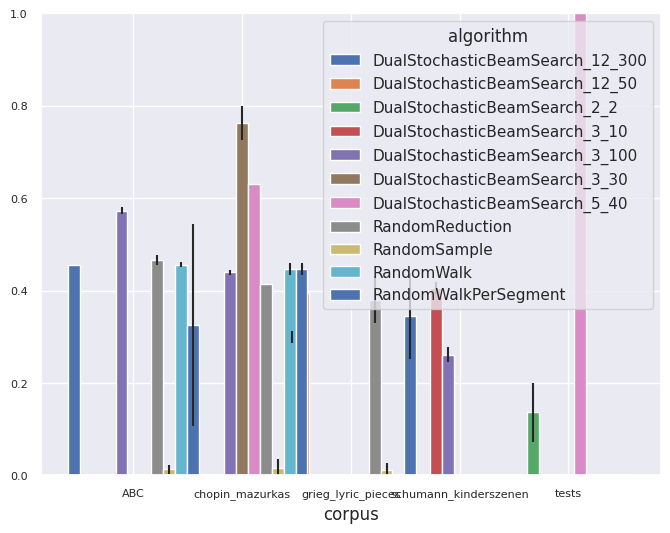

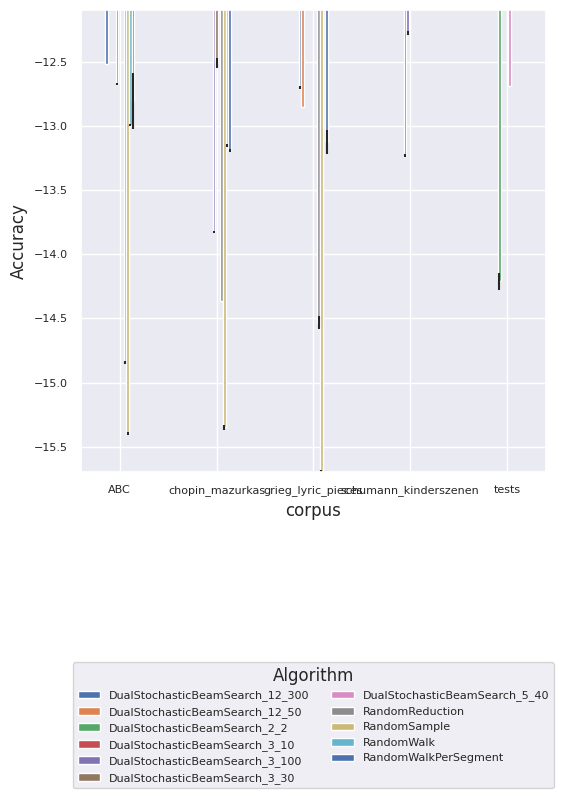

In [87]:
#fig, ax = plt.subplots(1, 2, figsize=((height*2)/ratio+ spacing,height),gridspec_kw={'width_ratios': [1,1]})
#lik_avgs.min().min(), lik_avgs.max().max()+ (lik_avgs.max().max()-lik_avgs.min().min()

sns.set()  # use Seaborn styles
#acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,2), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
r = acc_pivot.plot.bar( yerr=std_pivot,  figsize=(8,6), fontsize=8, rot=0, ylim=(0,1), width=1.2, legend="loc:lower center")
l = lik_pivot.plot.bar(yerr=std_pivot,  figsize=(6,6), fontsize=8, rot=0, ylim=(lik_pivot.min().min(),lik_pivot.max().max()), width=0.3, legend="loc:lower center")

plt.ylabel('Accuracy')
plt.legend(loc='upper center', title="Algorithm", bbox_to_anchor=(0.5, -0.4),
          fancybox=True, ncol=2, prop={'size': 8})
          

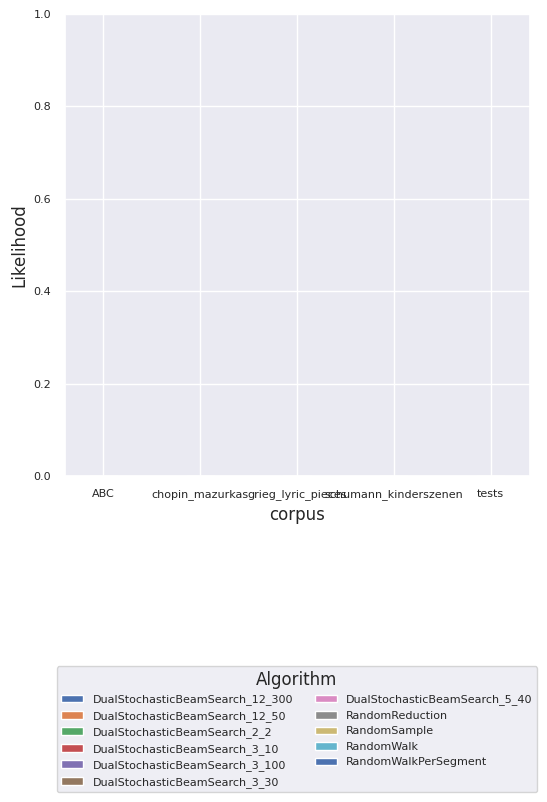

In [88]:
#r = acc_pivot.plot.bar( yerr=std_pivot,  figsize=(6,6), fontsize=8, rot=0, ylim=(0,1), width=0.3, legend="loc:lower center")

l = lik_pivot.plot.bar(figsize=(6,6), fontsize=8, rot=0, ylim=(0,1), width=0.3, legend="loc:lower center")

plt.ylabel('Likelihood')
plt.legend(loc='upper center', title="Algorithm", bbox_to_anchor=(0.5, -0.4),
          fancybox=True, ncol=2, prop={'size': 8})

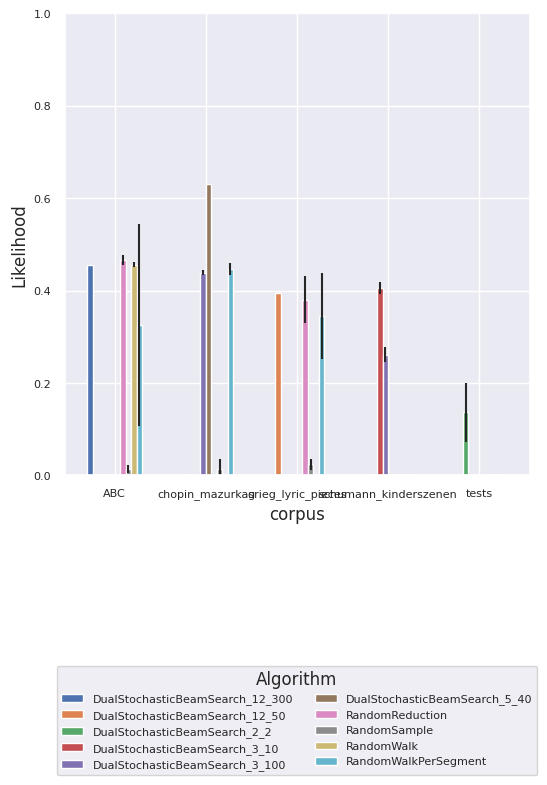

In [636]:
sns.set()  # use Seaborn styles
#acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,2), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,6), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")

plt.ylabel('Likelihood')
plt.legend(loc='upper center', title="Algorithm", bbox_to_anchor=(0.5, -0.4),
          fancybox=True, ncol=2, prop={'size': 8})

# Heuristic Search vs baseline with smaller beammm

### Choose specific experiement
202304-1700-0801 is the first experiment ran.
Includes 795 total runs. 
With Beam width 1-20 and reservoirs 200-4000 with gaps of 200.
Timeout was 400s, and only 72 runs completed within the time.

Next run will increase the timeout to 1000s, and narrow in the grid search region.

In [567]:

(results, labels) = get_latest_experiment("allexpssmaller")

Getting runs of allexpssmaller
Parsed 545 runs succesfully, consisting of 2 unique experiments with 110 failed runs
Viewing latest result: 2023-04-25 20:04:47


In [608]:
path = "outputs"
experiments, experiment_types = get_all_experiments(path)

In [612]:
results.index.get_level_values(0).max()

Timestamp('2023-04-25 20:04:47')

In [610]:
experiments

{'20230417222410_dual-stochastic-res-params',
 '20230417222926_dual-stochastic-res-params',
 '20230417230541_dual-stochastic-res-params',
 '20230417232707_dual-stochastic-res-params',
 '20230417232917_dual-stochastic-res-params',
 '20230417234107_dual-stochastic-res-params',
 '20230417234107_dual-stochastic-res-params-checkpoint',
 '20230417234922_dual-stochastic-res-params',
 '20230417235221_dual-stochastic-res-params',
 '20230417235446_dual-stochastic-res-params',
 '20230418000144_dual-stochastic-res-params',
 '20230418000536_dual-stochastic-res-params',
 '20230418000726_dual-stochastic-res-params',
 '20230418001926_dual-stochastic-res-params-grieg128',
 '20230418002216_dual-stochastic-res-params-grieg128',
 '20230418015420_dual-stochastic-res-500-400vs3-1-grieg128',
 '20230418053444_dual-stochastic-res-500-400vs3-1-grieg128',
 '20230418053444_dual-stochastic-res-500-400vs3-1-grieg128-checkpoint',
 '20230418074732_dual-stochastic-res-500-400vs3-1-grieg128',
 '20230418074732_dual-stoc

In [605]:
exp_id= "20230420212353"

In [606]:
(results, groundTruth) = get_experiments(exp_id)


Can't find experiment 20230420212353


 Extract parameters from algorithm name

We find that the run time increase heavily with both resovoir size and beam width. Close analysis finds that its a result of slices become very large, due to unspreads combining notes. We limit the evaluator to only applow unspreads produces slices up to size $\gamma$. For brevity, we choose a fixed reservoir size, 700.

### Choose specific experiement


In [594]:
results.algorithm.unique()

array(['RandomSample', 'RandomWalkPerSegment', 'RandomReduction',
       'DualStochasticBeamSearch_2_2', 'DualStochasticBeamSearch_3_10',
       'RandomWalk', 'DualStochasticBeamSearch_5_40',
       'DualStochasticBeamSearch_3_100'], dtype=object)

In [597]:
results

accuracy  \
id                  corpus             piece                     
2023-04-25 20:04:47 ABC                n13op130_06    0.019324   
                                       n13op130_06    0.022544   
                                       n15op132_04    0.141593   
                                       n15op132_04    0.132743   
                                       n15op132_04    0.000000   
                                       n15op132_04    0.008850   
                                       n05op18-5_02   0.520958   
                                       n05op18-5_02   0.508982   
                                       n10op74_04     0.473520   
                                       n10op74_04     0.457944   
                    tests              short          0.181818   
                                       short          0.090909   
                    grieg_lyric_pieces op68n02        0.419355   
                                       op68n02        0.430108   
                                       op12n02        0.416000   
                                       op12n02        0.344000   
                                       op65n02             NaN   
                                       op65n02             NaN   
                                       op57n01             NaN   
                                       op57n01             NaN   
                    chopin_mazurkas    BI89-1op24-1        NaN   
                                       BI89-1op24-1        NaN   
                                       BI71           0.008197   
                                       BI71           0.008197   
                                       BI16-2         0.021739   
                                       BI16-2         0.000000   
                                       BI16-2         0.630435   
                                       BI16-2         0.630435   
                                       BI105-3op30-3  0.018868   
                                       BI105-3op30-3  0.006289   
                                       BI153-2op56-2  0.442308   
                                       BI153-2op56-2  0.435897   
                                       BI77-3op17-3   0.009524   
                                       BI77-3op17-3   0.009524   
                                       BI145-1op50-1  0.032407   
                                       BI145-1op50-1  0.009259   
                                       BI61-5op07-5   0.078947   
                                       BI61-5op07-5   0.000000   

                                                                                            chordLabels  \
id                  corpus             piece                                                              
2023-04-25 20:04:47 ABC                n13op130_06    [DM, F♯Mm7, C♯o7, GM, Ao7, E♭Mm7, Do7, CM, A♭M...   
                                       n13op130_06    [AM, BM, AM, A♭Mm7, G♭M, DM, GM, F♯o7, BMm7, E...   
                                       n15op132_04    [EM, AM, AM, G♯o, AM, EMm7, AM, AM, AM, AM, DM...   
                                       n15op132_04    [EM, AM, AM, G♯o, AM, EMm7, AM, AM, AM, AM, DM...   
                                       n15op132_04    [B♭M, AMm7, BM, G♭M, CM, D♭M, FM, Cm, E♭M, GMm...   
                                       n15op132_04    [B♭M, FM, DM, F♯Mm7, FMm7, Ao7, GM, A♭Mm7, Eo,...   
                                       n05op18-5_02   [AM, EM, AM, AM, BM, AM, F♯M, BMm7, D♯M, BMm7,...   
                                       n05op18-5_02   [C♯M, EM, AM, AM, C♯M, AM, F♯M, DM, D♯M, BMm7,...   
                                       n10op74_04     [E♭M, E♭M, A♭M, Fm, Gmm7, B♭M, B♭M, B♭M, Gm, E...   
                                       n10op74_04     [E♭M, E♭M, A♭M, Fm, B♭M, B♭M, B♭M, B♭M, E♭M, E...   
                    tests              short             [FM, FM, CM, FM, DM, CMm7, FM, Dm, Gm, FM, FM]   
                      

In [595]:
results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).count()

accuracy  likelihood  \
corpus             algorithm                                              
ABC                RandomReduction                        2           2   
                   RandomSample                           4           4   
                   RandomWalkPerSegment                   4           4   
chopin_mazurkas    DualStochasticBeamSearch_3_100         2           2   
                   DualStochasticBeamSearch_5_40          2           2   
                   RandomSample                          12          12   
                   RandomWalkPerSegment                   0           0   
grieg_lyric_pieces DualStochasticBeamSearch_3_10          0           0   
                   RandomReduction                        2           2   
                   RandomWalk                             0           0   
                   RandomWalkPerSegment                   2           2   
tests              DualStochasticBeamSearch_2_2           2           2   

                                                   reRuns  runTime  reruns  \
corpus             algorithm                                                 
ABC                RandomReduction                      0        2       2   
                   RandomSample                         0        4       4   
                   RandomWalkPerSegment                 0        4       4   
chopin_mazurkas    DualStochasticBeamSearch_3_100       0        2       2   
                   DualStochasticBeamSearch_5_40        0        2       2   
                   RandomSample                         0       12      12   
                   RandomWalkPerSegment                 0        0       0   
grieg_lyric_pieces DualStochasticBeamSearch_3_10        0        0       0   
                   RandomReduction                      0        2       2   
                   RandomWalk                           0        0       0   
                   RandomWalkPerSegment                 0        2       2   
tests              DualStochasticBeamSearch_2_2         0        2       2   

                                                   experiment  
corpus             algorithm                                   
ABC                RandomReduction                          2  
                   RandomSample                             4  
                   RandomWalkPerSegment                     4  
chopin_mazurkas    DualStochasticBeamSearch_3_100           2  
                   DualStochasticBeamSearch_5_40            2  
                   RandomSample                            12  
                   RandomWalkPerSegment                     2  
grieg_lyric_pieces DualStochasticBeamSearch_3_10            2  
                   RandomReduction                          2  
                   RandomWalk                               2  
                   RandomWalkPerSegment                     2  
tests              DualStochasticBeamSearch_2_2             2

In [570]:
#results = results.drop(["id"],axis=1)

In [571]:
#results.drop(["chordLabels", "slices"], axis=1).groupby(["algorithm"]).agg([np.mean, np.std])

In [572]:
agm = results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm","piece"]).agg([np.mean, np.std])

/tmp/ipykernel_135821/3494776189.py:1: FutureWarning: ['experiment'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  agm = results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm","piece"]).agg([np.mean, np.std])


In [573]:
#results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).error

In [574]:
agm2 = agm.groupby(["corpus","algorithm"]).agg(np.mean)

In [575]:
errs = agm.reset_index()["accuracy"]["std"].fillna(0)

In [576]:
a = results.drop(["chordLabels", "slices"], axis=1)

In [577]:
std_pivot = pd.pivot_table(a, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.std)

In [578]:
acc_pivot = pd.pivot_table(a, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.mean)

In [579]:
lik_pivot = pd.pivot_table(a, 
                          values="likelihood", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.mean)

In [596]:
acc_pivot

algorithm,DualStochasticBeamSearch_2_2,DualStochasticBeamSearch_3_100,DualStochasticBeamSearch_5_40,RandomReduction,RandomSample,RandomWalkPerSegment
corpus,,,,,,
ABC,NaN,NaN,NaN,0.465732,0.012679,0.326069
chopin_mazurkas,NaN,0.439103,0.630435,NaN,0.016913,NaN
grieg_lyric_pieces,NaN,NaN,NaN,0.380000,NaN,0.424731
tests,0.136364,NaN,NaN,NaN,NaN,NaN


In [581]:
lik_pivot

algorithm,DualStochasticBeamSearch_2_2,DualStochasticBeamSearch_3_100,DualStochasticBeamSearch_5_40,RandomReduction,RandomSample,RandomWalkPerSegment
corpus,,,,,,
ABC,NaN,NaN,NaN,-14.841916,-15.129499,-12.805580
chopin_mazurkas,NaN,-13.82622,-12.096775,NaN,-15.373929,NaN
grieg_lyric_pieces,NaN,NaN,NaN,-14.533144,NaN,-12.668857
tests,-14.21107,NaN,NaN,NaN,NaN,NaN


## Plot Accuracy Chart

In [582]:
ratio = 1
height = 5

In [583]:
lik_pivot.max().max()

-12.096774557551374

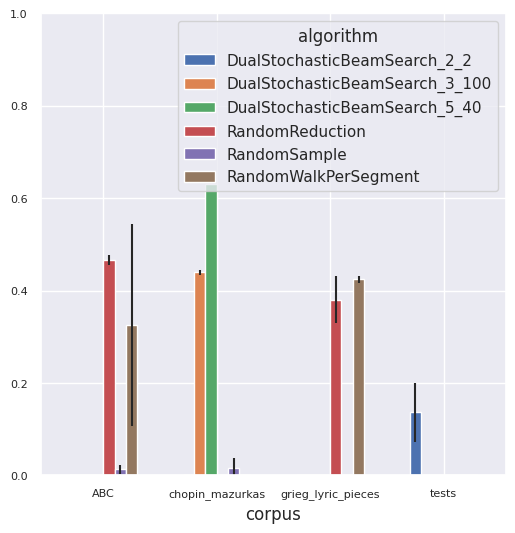

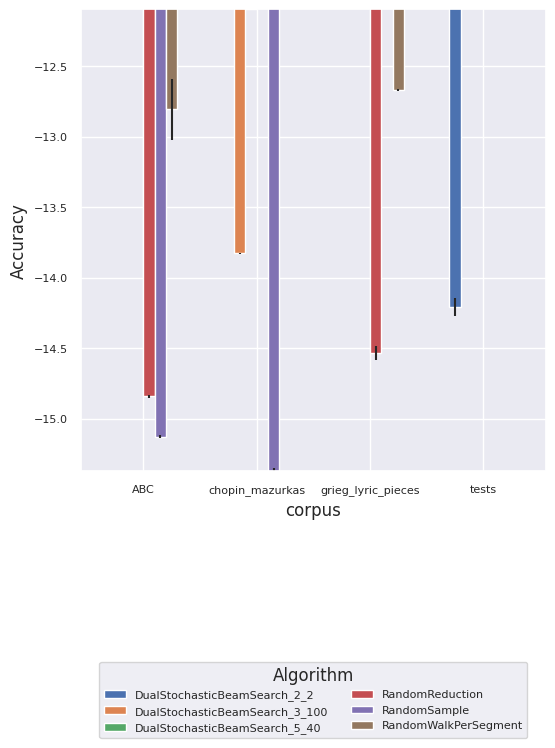

In [584]:
#fig, ax = plt.subplots(1, 2, figsize=((height*2)/ratio+ spacing,height),gridspec_kw={'width_ratios': [1,1]})
#lik_avgs.min().min(), lik_avgs.max().max()+ (lik_avgs.max().max()-lik_avgs.min().min()

sns.set()  # use Seaborn styles
#acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,2), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
r = acc_pivot.plot.bar( yerr=std_pivot,  figsize=(6,6), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
l = lik_pivot.plot.bar(yerr=std_pivot,  figsize=(6,6), fontsize=8, rot=0, ylim=(lik_pivot.min().min(),lik_pivot.max().max()), width=0.6, legend="loc:lower center")

plt.ylabel('Accuracy')
plt.legend(loc='upper center', title="Algorithm", bbox_to_anchor=(0.5, -0.4),
          fancybox=True, ncol=2, prop={'size': 8})
          

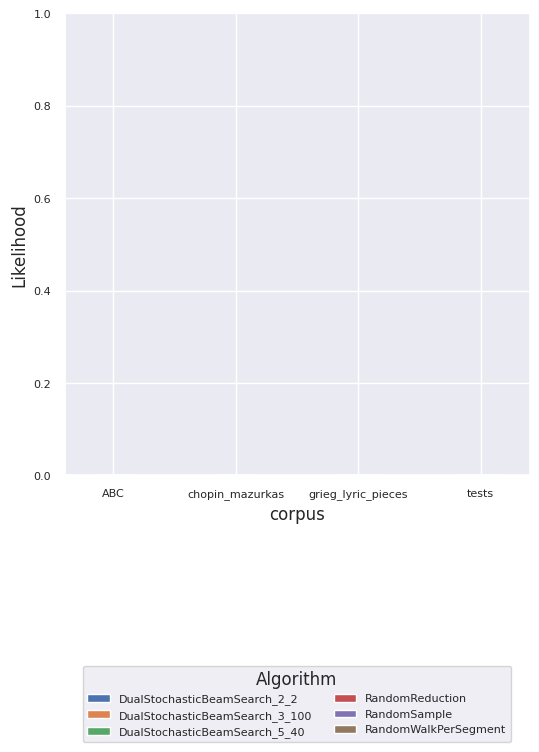

In [585]:
#r = acc_pivot.plot.bar( yerr=std_pivot,  figsize=(6,6), fontsize=8, rot=0, ylim=(0,1), width=0.3, legend="loc:lower center")

l = lik_pivot.plot.bar(figsize=(6,6), fontsize=8, rot=0, ylim=(0,1), width=0.3, legend="loc:lower center")

plt.ylabel('Likelihood')
plt.legend(loc='upper center', title="Algorithm", bbox_to_anchor=(0.5, -0.4),
          fancybox=True, ncol=2, prop={'size': 8})

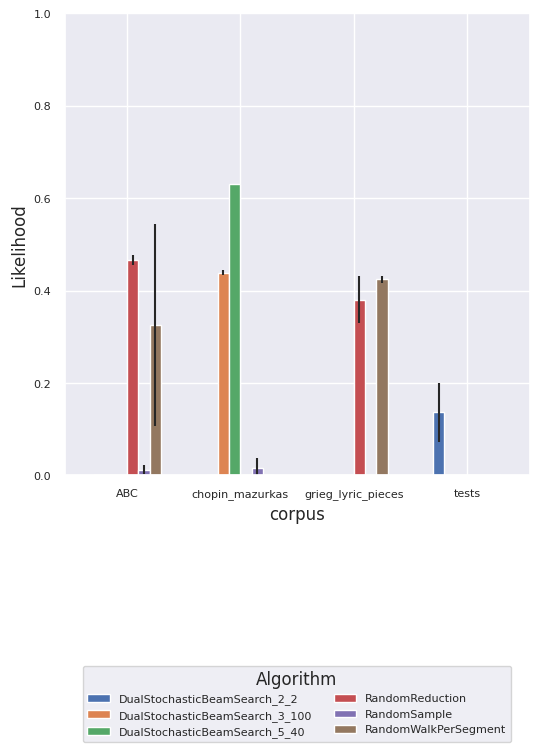

In [586]:
sns.set()  # use Seaborn styles
#acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,2), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,6), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")

plt.ylabel('Likelihood')
plt.legend(loc='upper center', title="Algorithm", bbox_to_anchor=(0.5, -0.4),
          fancybox=True, ncol=2, prop={'size': 8})

In [587]:
exp_id = "202304-1715-2135"

In [588]:
exp_df = results.xs(exp_id,level=1)

KeyError: '202304-1715-2135'

In [ ]:
stochastic_params_lim_df = exp_df.xs("stochastic-limited-fixed-res",level=0)

In [ ]:
stochastic_params_lim_df

 Extract parameters from algorithm name

In [ ]:
stochastic_params_lim_df['beamwidth'] = stochastic_params_lim_df["algorithm"].apply(lambda s: int(s.split("_")[1]))
stochastic_params_lim_df['limit'] = stochastic_params_lim_df["algorithm"].apply(lambda s: int(s.split("_")[3]))

## Accuracy, loglikelihood and runtime

In [ ]:
def get_avgs(df, value):
    g = df.dropna(subset=value).groupby(['beamwidth','limit'])
    df_means = g[value].mean()
    return df_means.loc[:,:].reset_index().pivot(index='limit', columns='beamwidth', values=value)

In [ ]:
acc_avgs = get_avgs(stochastic_params_lim_df, 'accuracy')
lik_avgs = get_avgs(stochastic_params_lim_df, 'likelihood')
run_avgs = get_avgs(stochastic_params_lim_df, 'runTime')

## Plot hyperparemter results

In [ ]:
def create_heatmap(xs, ax, vmin, vmax,cmap):
    lbls = xs.applymap(lambda v: "{:.2f}".format(v) if v in [np.nanmax(xs.values),np.nanmin(xs.values)]else '')
    return sns.heatmap(xs,
            square=True,
            ax=ax,
            cmap=cmap,
            fmt='',
            annot=lbls, # Label the maximum value
            annot_kws={'fontsize':5},
            mask=xs.isna(),
            vmax=vmax,
            vmin=vmin,
            linewidth=0.01)

In [ ]:
height=5
ratio = stochastic_params_lim_df['limit'].nunique() / stochastic_params_lim_df['beamwidth'].nunique()
spacing = 1
fig, ax = plt.subplots(1, 3, figsize=((height*3)/ratio+ spacing,height),gridspec_kw={'width_ratios': [1,1,1]})

cmap = sns.color_palette("viridis", as_cmap=True)
cmap.set_bad(color="black")

l = create_heatmap(lik_avgs, ax[0], lik_avgs.min().min(), lik_avgs.max().max()+ (lik_avgs.max().max()-lik_avgs.min().min()) * 0.1, cmap)
a = create_heatmap(acc_avgs, ax[1], 0, 1, cmap)
r = create_heatmap(run_avgs, ax[2], run_avgs.min().min(), run_avgs.max().max(), cmap.reversed())

ax[0].set_title('Log-likelihood')
ax[1].set_title('Accuracy')
ax[2].set_title('Run-time (s)')

for a in ax:
    a.set_xlabel('Beam Width')
    a.set_ylabel('Slice Limit')


plt.tight_layout()
plt.savefig('plots/stochbeamlimgridsearch-{}.png'.format(exp_id), dpi=180)

# Analysis on latest experiment

In [ ]:
results = results.drop(["id"],axis=1)

In [ ]:
#results.drop(["chordLabels", "slices"], axis=1).groupby(["algorithm"]).agg([np.mean, np.std])

In [ ]:
agm = results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).agg([np.mean, np.std])

In [ ]:
#results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).errors()

In [ ]:
agm = results.drop(["chordLabels", "slices","runTime","likelihood"], axis=1).groupby(["corpus", "algorithm"]).agg([np.std])

In [ ]:
errs = agm.reset_index()["accuracy"]["std"].fillna(0)

In [ ]:
a = results.drop(["chordLabels", "slices"], axis=1)

In [ ]:
std_pivot = pd.pivot_table(a, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.std)

In [ ]:
acc_pivot = pd.pivot_table(a, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.mean)

## Plot Accuracy Chart

In [ ]:
sns.set()  # use Seaborn styles
#acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,2), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
#acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,2), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
#plt.ylabel('Accuracy')
#plt.legend(loc='upper center', title="Algorithm", bbox_to_anchor=(0.5, -0.4),
          fancybox=True, ncol=2, prop={'size': 8})
          

# Close Error Analysis

Attributes: chord type, root note, etc

#### Zoom in on ABC: n02op18-2_03

In [ ]:
groundTruth.loc['ABC','n02op18-2_03']

In [ ]:
results

In [ ]:
ex = results.loc['schumann_kinderszenen','n04']

In [ ]:
ex[["algorithm", "accuracy", "likelihood", "runTime"]]

In [ ]:
experiments, experiment_types = get_all_experiments("outputs")